# CONTENT <a class="anchor" name="content"></a>

>[CONTENT](#content)

>>[Packages](#packages)

>>[Plots Utils](#plot_utils)

>>[Introduction](#introduction)

>>[Distribution of Targets](#distribution_of_targets)

>>[Categorical features](#сategorical_features)

>>[Cumulative Incomes](#incomes)

>>>[Top countries by full_ltv_day30](#top_countries_by_full_ltv_day30)

>>>[Top media-sources by full_ltv_day30](#top_media_sources_by_full_ltv_day30)

>>[Game currency](#game_currency)

>>>[Anomaly detection](#anomaly_detection)

>>>[Correlation plots](#correlation_plots)

>>>[Categorical varaibles and currency](#categorical_varaibles_and_currency)

>>>[Correlation maps for discrete variables](#correlation_maps_for_discrete_variables)

>>[Activity 1](#activity_1)

>>>[Cumulative values](#cumulative_values)

>>>[Comparing discrete values](#comparing_discrete_values)

>>>[Correlation analysis](#correlation_analysis)

>>[Activity 2](#activity_2)

>>>[Additional plot utils](#additional_plot_utils)

>>>[Dataset preparation](#dataset_preparation)

>>>[Distributions](#distributions)

>>[Summary](#summary)

>>[Select Top Categories & One-Hot Encoding](#select_top_categories_&_one_hot_encoding)

>>[Converting cumulative values to discrete](#converting_cumulative_values_to_discrete)

>>[Model Building&Interpretation Utils](#model_building&_interpretation_utils)

>>[Model Training](#model_training)




## Packages <a class="anchor" name="packages"></a>

In [6]:
!pip install scikit-optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial

from xgboost.sklearn import XGBRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestRegressor

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import pickle

import warnings
warnings.filterwarnings('ignore')

In [8]:
pd.options.display.max_rows = 150
pd.options.display.max_columns = 100

In [9]:
sns.set_style('darkgrid')
TARGET = 'target_full_ltv_day30'
SUBTARGETS = ['target_sub_ltv_day30', 'target_iap_ltv_day30', 'target_ad_ltv_day30']

In [10]:
df = pd.read_csv('dataset.csv')
df[TARGET] = df[SUBTARGETS].sum(axis=1)
initial_df = df

In [11]:
df = df.fillna(0)

In [12]:
df.columns

Index(['total_sessions_day0', 'total_sessions_day1', 'total_sessions_day3',
       'total_sessions_day7', 'chapters_finished_day0',
       'chapters_finished_day1', 'chapters_finished_day3',
       'chapters_finished_day7', 'chapters_opened_day0',
       'chapters_opened_day1', 'chapters_opened_day3', 'chapters_opened_day7',
       'chapters_closed_day0', 'chapters_closed_day1', 'chapters_closed_day3',
       'chapters_closed_day7', 'diamonds_received_day0',
       'diamonds_received_day1', 'diamonds_received_day3',
       'diamonds_received_day7', 'diamonds_spent_day0', 'diamonds_spent_day1',
       'diamonds_spent_day3', 'diamonds_spent_day7', 'tickets_spent_day0',
       'tickets_spent_day1', 'tickets_spent_day3', 'tickets_spent_day7',
       'retained_day1', 'retained_day3', 'retained_day7',
       'chapters_finished_session1', 'chapters_finished_session3',
       'chapters_finished_session9', 'chapters_opened_session1',
       'chapters_opened_session3', 'chapters_opened_session9'

In [13]:
df['install_date'] = pd.to_datetime(df['install_date'])

In [14]:
countries = df['country_code'].unique()
countries

array(['COUNTRY_135', 'COUNTRY_141', 'COUNTRY_203', 'COUNTRY_38',
       'COUNTRY_132', 'COUNTRY_45', 'COUNTRY_153', 'COUNTRY_123',
       'COUNTRY_155', 'COUNTRY_85', 'COUNTRY_13', 'COUNTRY_114',
       'COUNTRY_113', 'COUNTRY_211', 'COUNTRY_72', 'COUNTRY_8',
       'COUNTRY_137', 'COUNTRY_32', 'COUNTRY_52', 'COUNTRY_68',
       'COUNTRY_35', 'COUNTRY_15', 'COUNTRY_194', 'COUNTRY_129',
       'COUNTRY_110', 'COUNTRY_26', 'COUNTRY_106', 'COUNTRY_218',
       'COUNTRY_24', 'COUNTRY_144', 'COUNTRY_80', 'COUNTRY_23',
       'COUNTRY_102', 'COUNTRY_200', 'COUNTRY_49', 'COUNTRY_165',
       'COUNTRY_208', 'COUNTRY_156', 'COUNTRY_42', 'COUNTRY_67',
       'COUNTRY_6', 'COUNTRY_14', 'COUNTRY_217', 'COUNTRY_158',
       'COUNTRY_7', 'COUNTRY_60', 'COUNTRY_9', 'COUNTRY_5', 'COUNTRY_190',
       'COUNTRY_192', 'COUNTRY_223', 'COUNTRY_41', 'COUNTRY_89',
       'COUNTRY_164', 'COUNTRY_56', 'COUNTRY_189', 'COUNTRY_204',
       'COUNTRY_91', 'COUNTRY_109', 'COUNTRY_95', 'COUNTRY_115',
       'COUNTR

In [15]:
media = df['media_source'].unique()
media

array(['SOURCE_23', 'SOURCE_2', 'SOURCE_17', 'SOURCE_1', 'SOURCE_10',
       'SOURCE_18', 'SOURCE_9', 'SOURCE_5', 'SOURCE_3', 'SOURCE_6',
       'SOURCE_16', 'SOURCE_7', 'SOURCE_12', 'SOURCE_8', 'SOURCE_21',
       'SOURCE_13', 'SOURCE_4', 'SOURCE_19', 'SOURCE_14', 'SOURCE_11',
       'SOURCE_22', 'SOURCE_15', 'SOURCE_20', 'SOURCE_0'], dtype=object)

In [16]:
len(countries), len(media)

(224, 24)

In dataset are *224* different **countries** and *24* **media sources**.

In [17]:
ios = df[df['platform'] == 'ios']
android = df[df['platform'] == 'android']

len(ios), len(android)

(580406, 887426)

We deal with *580406* **IOS** and *887426* **Android** users.

## Plots Utils <a class="anchor" name="plot_utils"></a>

In [18]:
def handle_outliers(df, feature, method='drop'):
    """
    Splits dataset based on the platform and removes outliers using IQR

    Q1 - 1.5 * IQR < X < Q3 + 1.5 * IQR

    Returns splited data
    """
    df = df[df[feature] > 1]
    ios_df = df[df['platform'] == 'ios']
    android_df = df[df['platform'] == 'android']

    ios_q1, ios_q3 = ios_df[feature].quantile(0.25), ios_df[feature].quantile(0.75)
    android_q1, android_q3 = android_df[feature].quantile(0.25), android_df[feature].quantile(0.75)
    
    ios_iqr = ios_q3-ios_q1
    android_iqr = android_q3-android_q1

    ios_lower_bound, ios_upper_bound = ios_q1 - (1.5 * ios_iqr), ios_q3 + (1.5 * ios_iqr)
    android_lower_bound, android_upper_bound = android_q1 - (1.5 * android_iqr), android_q3 + (1.5 * android_iqr)


    if method == 'replace':
        ios_df.loc[ios_df[feature] > ios_upper_bound, feature] = ios_q3
        ios_df.loc[ios_df[feature] < ios_lower_bound, feature] = ios_q1

        android_df.loc[android_df[feature] > android_upper_bound, feature] = android_q3
        android_df.loc[android_df[feature] < android_lower_bound, feature] = android_q1

    elif method == 'drop':
        ios_df = ios_df[(ios_df[feature] < ios_upper_bound) & (ios_df[feature] > ios_lower_bound)]
        android_df = android_df[(android_df[feature] < android_upper_bound) & (android_df[feature] > android_lower_bound)]

    return ios_df, android_df


def scatter_plt(df, feature, visualise):
    '''
    Plots a scatter plot of variable visualise grouped by feature values'
    '''
    unq_val = df[feature].unique()
    df_cop = df.copy()
    df_cop['idx'] = df.index

    for val in unq_val:
        temp_df =  df_cop[df_cop[feature] == val] 
        plt.scatter(temp_df['idx'], temp_df[visualise], label = val)
    
    plt.legend()
    plt.title(f'{visualise} distribution')
    plt.show()

def handle_negative(data, features, flag = False):
    """
    Detects and deletes negative values in distributions
    """
    
    for feature in features:
                
        if flag:
            data = data[data[feature] >= 0]
        
        else:
            negative = data[data[feature] < 0]
            print(negative[feature])
   
    return data


def describe_feature(df, features):
    """
    Returns features descriptive statistics
    """
    df = df.drop([col for col in df.columns if col not in features], axis=1)

    
    df_describe = df.describe()
    variance = []
    percentages = []
    
    for feature in features:
        variance.append(df[feature].var())
        percentages.append(len(df.loc[df[feature] <= 0.2])/len(df))

        
    df_describe.loc['var'] = variance
    df_describe.loc['zero_density'] = percentages
    return df_describe

def category_range(data, ranges, feature, group_by):
    '''
    Groups feature values by ranges and by parameter group_by
    '''
    
    fig, axes = plt.subplots(nrows=len(ranges), ncols=1, figsize=(len(ranges)*3, len(ranges)*3))

    
    for _,i in enumerate(ranges):
        
        temp_df = data[(data[feature] >= i[0]) & (data[feature] < i[1])]
        df = temp_df.value_counts(group_by)
        
        ax1 = axes[_]
    
        sns.barplot(df.index, df.values, alpha=0.8, ax=ax1)
        ax1.set_title(f'Range: {i[0]} <= {feature} < {i[1]}')
      
    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=1.5, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.4)

    plt.show()

def show_distribution(ios_df, android_df, features):
    """
    Plots density and boxplots for features of provided IOS and Android datasets
    """
    n = len(features)
    fig, axes = plt.subplots(nrows=n, ncols=2, figsize=(n*3, n*3))

    for i, feature in enumerate(features):
        ios_data = ios_df[feature]
        android_data = android_df[feature]

        ax1, ax2 = axes[i, 0], axes[i, 1]

        sns.distplot(ios_data, ax=ax1, label="ios")
        sns.distplot(android_data, ax=ax1, label="android")
        sns.boxplot(None, ios_data, ax=ax2)
        sns.boxplot(None, android_data, ax=ax2)

        ax1.set_title(f'{feature} Density')
        ax2.set_title(f'{feature} Boxplot')

        if i == 0:
            fig.legend()

    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=1.5, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.4)
    plt.show()

def show_cat_distribution(df, features):
    n = len(features)
    fig, axes = plt.subplots(nrows=n, ncols=1, figsize=(1*5, n*5))

    for i, feature in enumerate(features):
        ax = axes[i]

        sns.histplot(df, x=feature, ax=ax, discrete=True, shrink=0.8)

        ax.set_title(f'{feature} Count Plot')
        ax.tick_params(axis='x', labelrotation=-90)

    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=1.5, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.4)
    plt.show()
    
    fig.clear()
    plt.close(fig)

def plot_heatmaps(ios_df, android_df, features):
    """
    Plots correlation of features given IOS and Android datasets
    """
    ios_df = ios_df[features]
    android_df = android_df[features]

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

    sns.heatmap(ios_df.corr(), annot=True, ax=ax1)
    sns.heatmap(android_df.corr(), annot=True, ax=ax2)

    ax1.set_title(f'IOS Correlation')
    ax2.set_title(f'Android Correlation')

    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=1.5, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

    plt.show()

def plot_hist_grouped_by(ios_df, android_df, group_by, feature):
    """
    Prints out 10 most significant groups for both platforms based on given
    feature given IOS and Android datasets
    """
    ios_grouped_sum = ios_df.groupby(group_by)[feature].sum()
    ios_grouped_sum = ios_grouped_sum.sort_values(ascending=False)
    ios_values = ios_grouped_sum.values
    ios_indeces = ios_grouped_sum.index

    android_grouped_sum = android_df.groupby(group_by)[feature].sum()
    android_grouped_sum = android_grouped_sum.sort_values(ascending=False)
    android_values = android_grouped_sum.values
    android_indeces = android_grouped_sum.index

    grouped = {
                'ios': [ios_values, ios_indeces],
                'android': [android_values, android_indeces]
                }

    for platform in ['IOS', 'Android']:
    
        print(f'Top {min(10, len(grouped[platform.lower()][0]))} sum {group_by} based on {feature} ({platform})')

        i = 1
        for val, ind in zip(*grouped[platform.lower()]):
            if i > 10:
                break
            print(f'{i}. {ind}: {val}')
            i += 1
    
        print('\n')

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

    f1 = sns.barplot(ios_indeces, ios_values, ax=ax1)
    f2 = sns.barplot(android_indeces, android_values, ax=ax2)
    ax1.set_title(f'Barplot grouped by {group_by} (IOS)')
    ax1.set_ylabel(feature)
    ax2.set_title(f'Barplot grouped by {group_by} (Android)')
    ax2.set_ylabel(feature)
    f1.set_xticklabels(['' for _ in range(len(ios_values))])
    f2.set_xticklabels(['' for _ in range(len(android_values))])
    plt.show()

def select_top_n(df, group_by, feature, n):
    """
    Selects out n categories that are the most significant in given feature
    """
    grouped_sum = df.groupby(group_by)[feature].sum().sort_values(ascending=False)

    indeces = grouped_sum.index

    return indeces[:n]

def merge_unpopular_categories(df, category, top_categories):
    """
    Merges rare categories into 'OTHER' category
    """
    df[category] = df[category].apply(lambda cat:
                                      cat if cat in top_categories
                                          else f'OTHER_{category}')

    return df

## Other Utils

In [19]:
def get_target_columns(df, feature):
    '''
    Returns sorted list of cummulative columns for feature

    Ex. 
        For total_sessions_day returns:
        [total_sessions_day0, total_sessions_day1, total_sessions_day3, ...]
    '''
    cummulative_columns = [col for col in df.columns if (feature in col and col not in [TARGET]+SUBTARGETS)]
    cummulative_columns.sort()

    return cummulative_columns

def transform_cumulative_to_discrete(df, feature, prefix='disc'):
    '''
    Appends discrete columns to the df and returns transformed df
    '''
    target_cols = get_target_columns(df, feature)
    target_cols = [col for col in target_cols if prefix not in col]
    target_cols.sort()
    transformed_cols = []

    for i in reversed(range(len(target_cols))):
        col = target_cols[i]
        new_col = f'{prefix}_{col}'

        if i == 0:
            df[new_col] = df[col]
        else:
            prev_col = target_cols[i - 1]
            df[new_col] = df[col] - df[prev_col] 

        transformed_cols.append(new_col)

    df = df.drop(columns=target_cols)

    return df

def transform_all_cumulative(df, features):
    for feature in features:
        df = transform_cumulative_to_discrete(df, feature)

    return df

## Introduction <a class="anchor" name="introduction"></a>

There are 4 guys in our team. Therefore, we splitted all variables in 5 groups.

The 5 groups are:
* Categorical features:
1. **install_date**
2. **country_code**
3. **platform**
* Incomes:
1. **app_sub_ltv_day{N}**
2. **app_iap_ltv_day{N}**
3. **ad_ltv_day{N}** 
* Currency:
1. **diamonds_received_day{N}**
2. **diamonds_spent_day{N}**
3. **tickets_spent_day{N}**
4. **tickets_spent_session{N}**
5. **diamonds_spent_session{N}**
* Activity 1:
1. **total_sessions_day{N}**
2. **chapters_finished_session{N}**
3. **chapters_opened_session{N}**
4. **chapters_closed_session{N}**
* Activity 2:
1. **chapters_finished_day{N}**
2. **chapters_opened_day{N}**
3. **retained_day{N}**

Each group analysis is presented in separate part of EDA.

Also, we assume that IOS and Android users has different feature and payability distributions. So, mostly analyzed users from each platform separately.

During EDA we will check this assumption. If it is true, it is worth to build separate model for each platform.

## Distribution of Targets <a class="anchor" name="distribution_of_targets"></a>

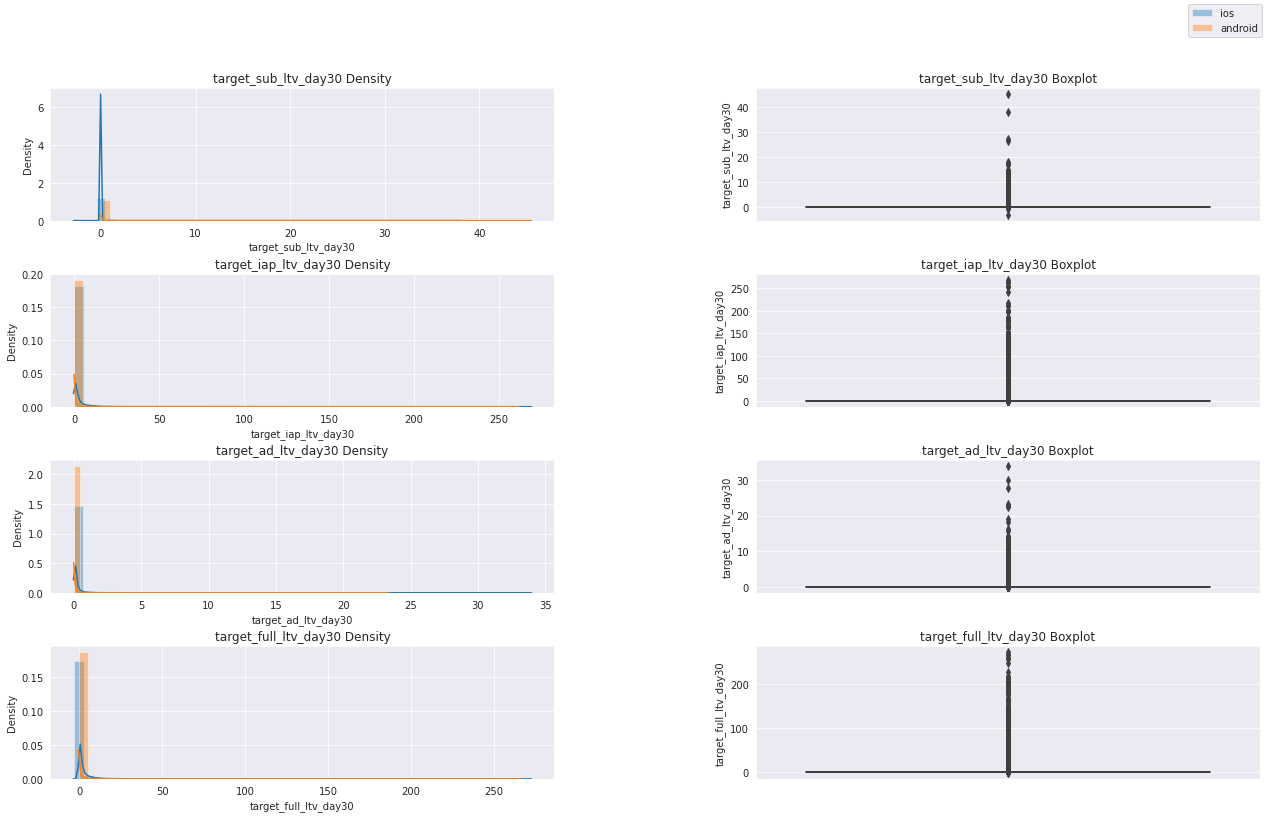

In [20]:
show_distribution(ios, android, SUBTARGETS + [TARGET])

It seems that bigger part of users are **insolvent**, therefore it is neccessary to eliminate such for further analysis.

In [21]:
denoised_ios_df, denoised_android_df = handle_outliers(df, TARGET, 'drop')

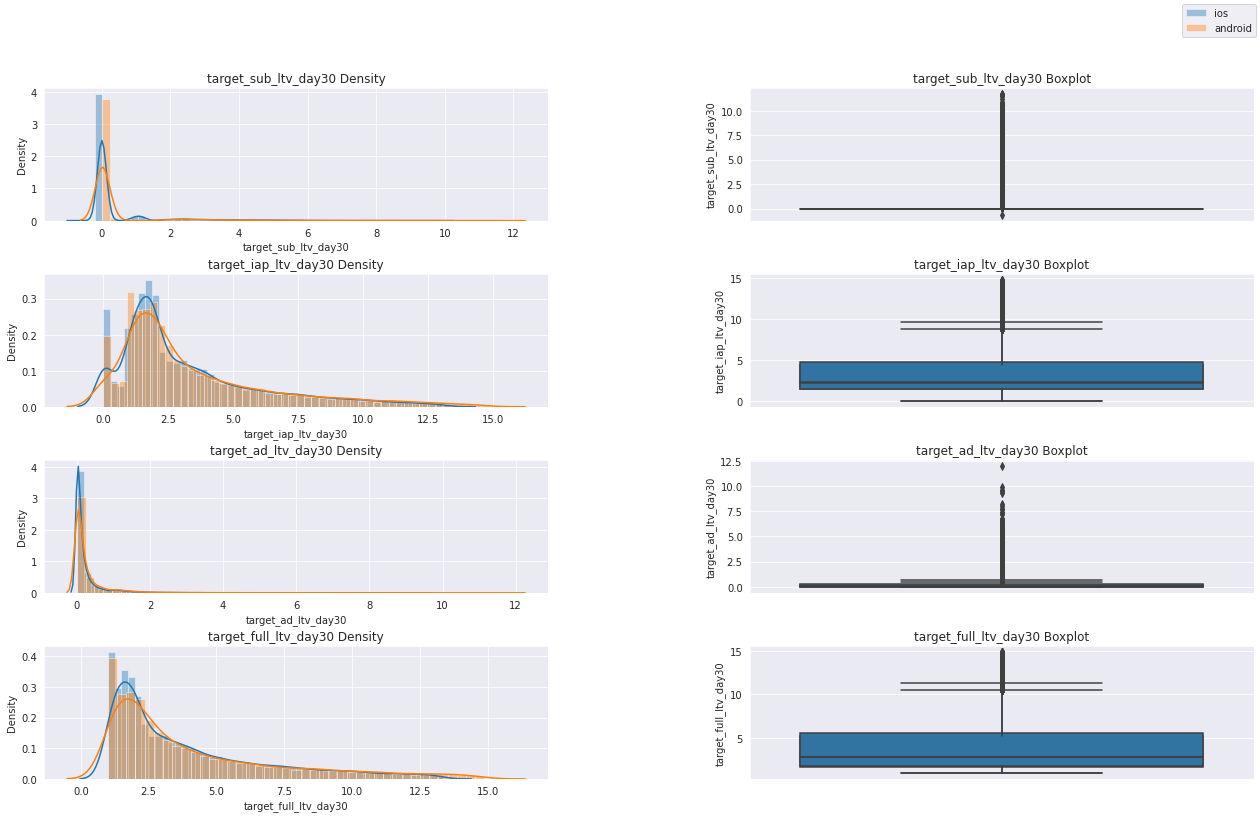

In [22]:
show_distribution(denoised_ios_df, denoised_android_df, SUBTARGETS + [TARGET])

From these densities it seems that **most of incomes** are from **purchasing gems and tickets**. Very few part comes from advert and subscriptions.

## Categorical features <a class="anchor" name="сategorical_features"></a>

IOS Distributions


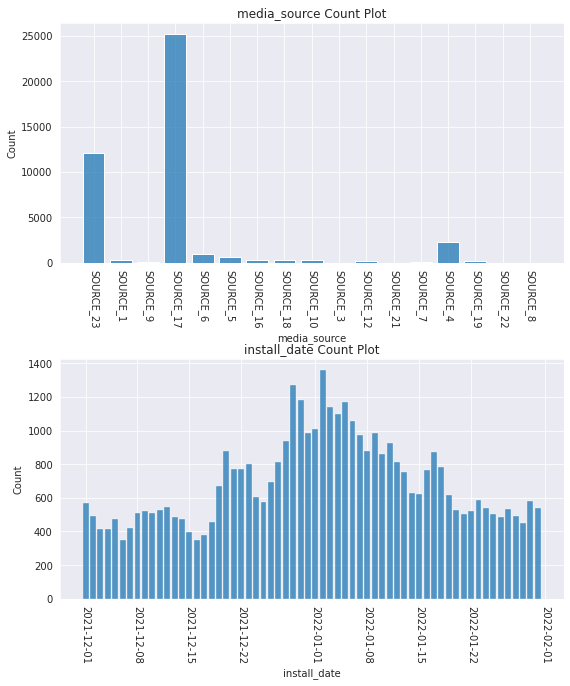

Android Distributions


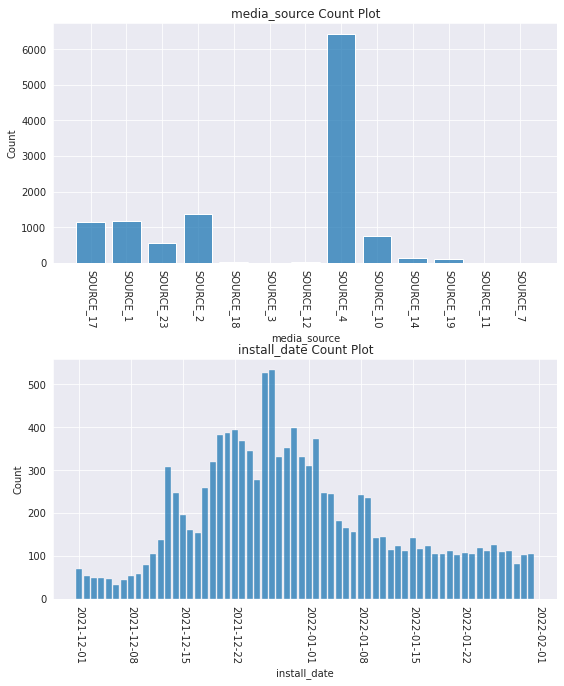

In [23]:
print("IOS Distributions")
show_cat_distribution(denoised_ios_df, ['media_source', 'install_date'])
print("Android Distributions")
show_cat_distribution(denoised_android_df, ['media_source', 'install_date'])

Most Android users installed app near New Year. Whereas installed dates of IOS is more uniform.  
It seems that advertisement was conducted near New Year. We don't know what advertisements will be posted later. Therefore, we can't use install_date feature for future predictions.

Most Android users - from SOURCE_4, most IOS users - from SOURCE_23 and SOURCE_23.  
This feature greatly associates with platform, So, it may be dropped.

## **Cumulative Incomes** <a class="anchor" name="incomes"></a>

As for cumulative incomes we have 3 different sources:
* **app_sub_ltv_day{N}**
* **app_iap_ltv_day{N}**
* **ad_ltv_day{N}** 

Let's take a look at their distributions.

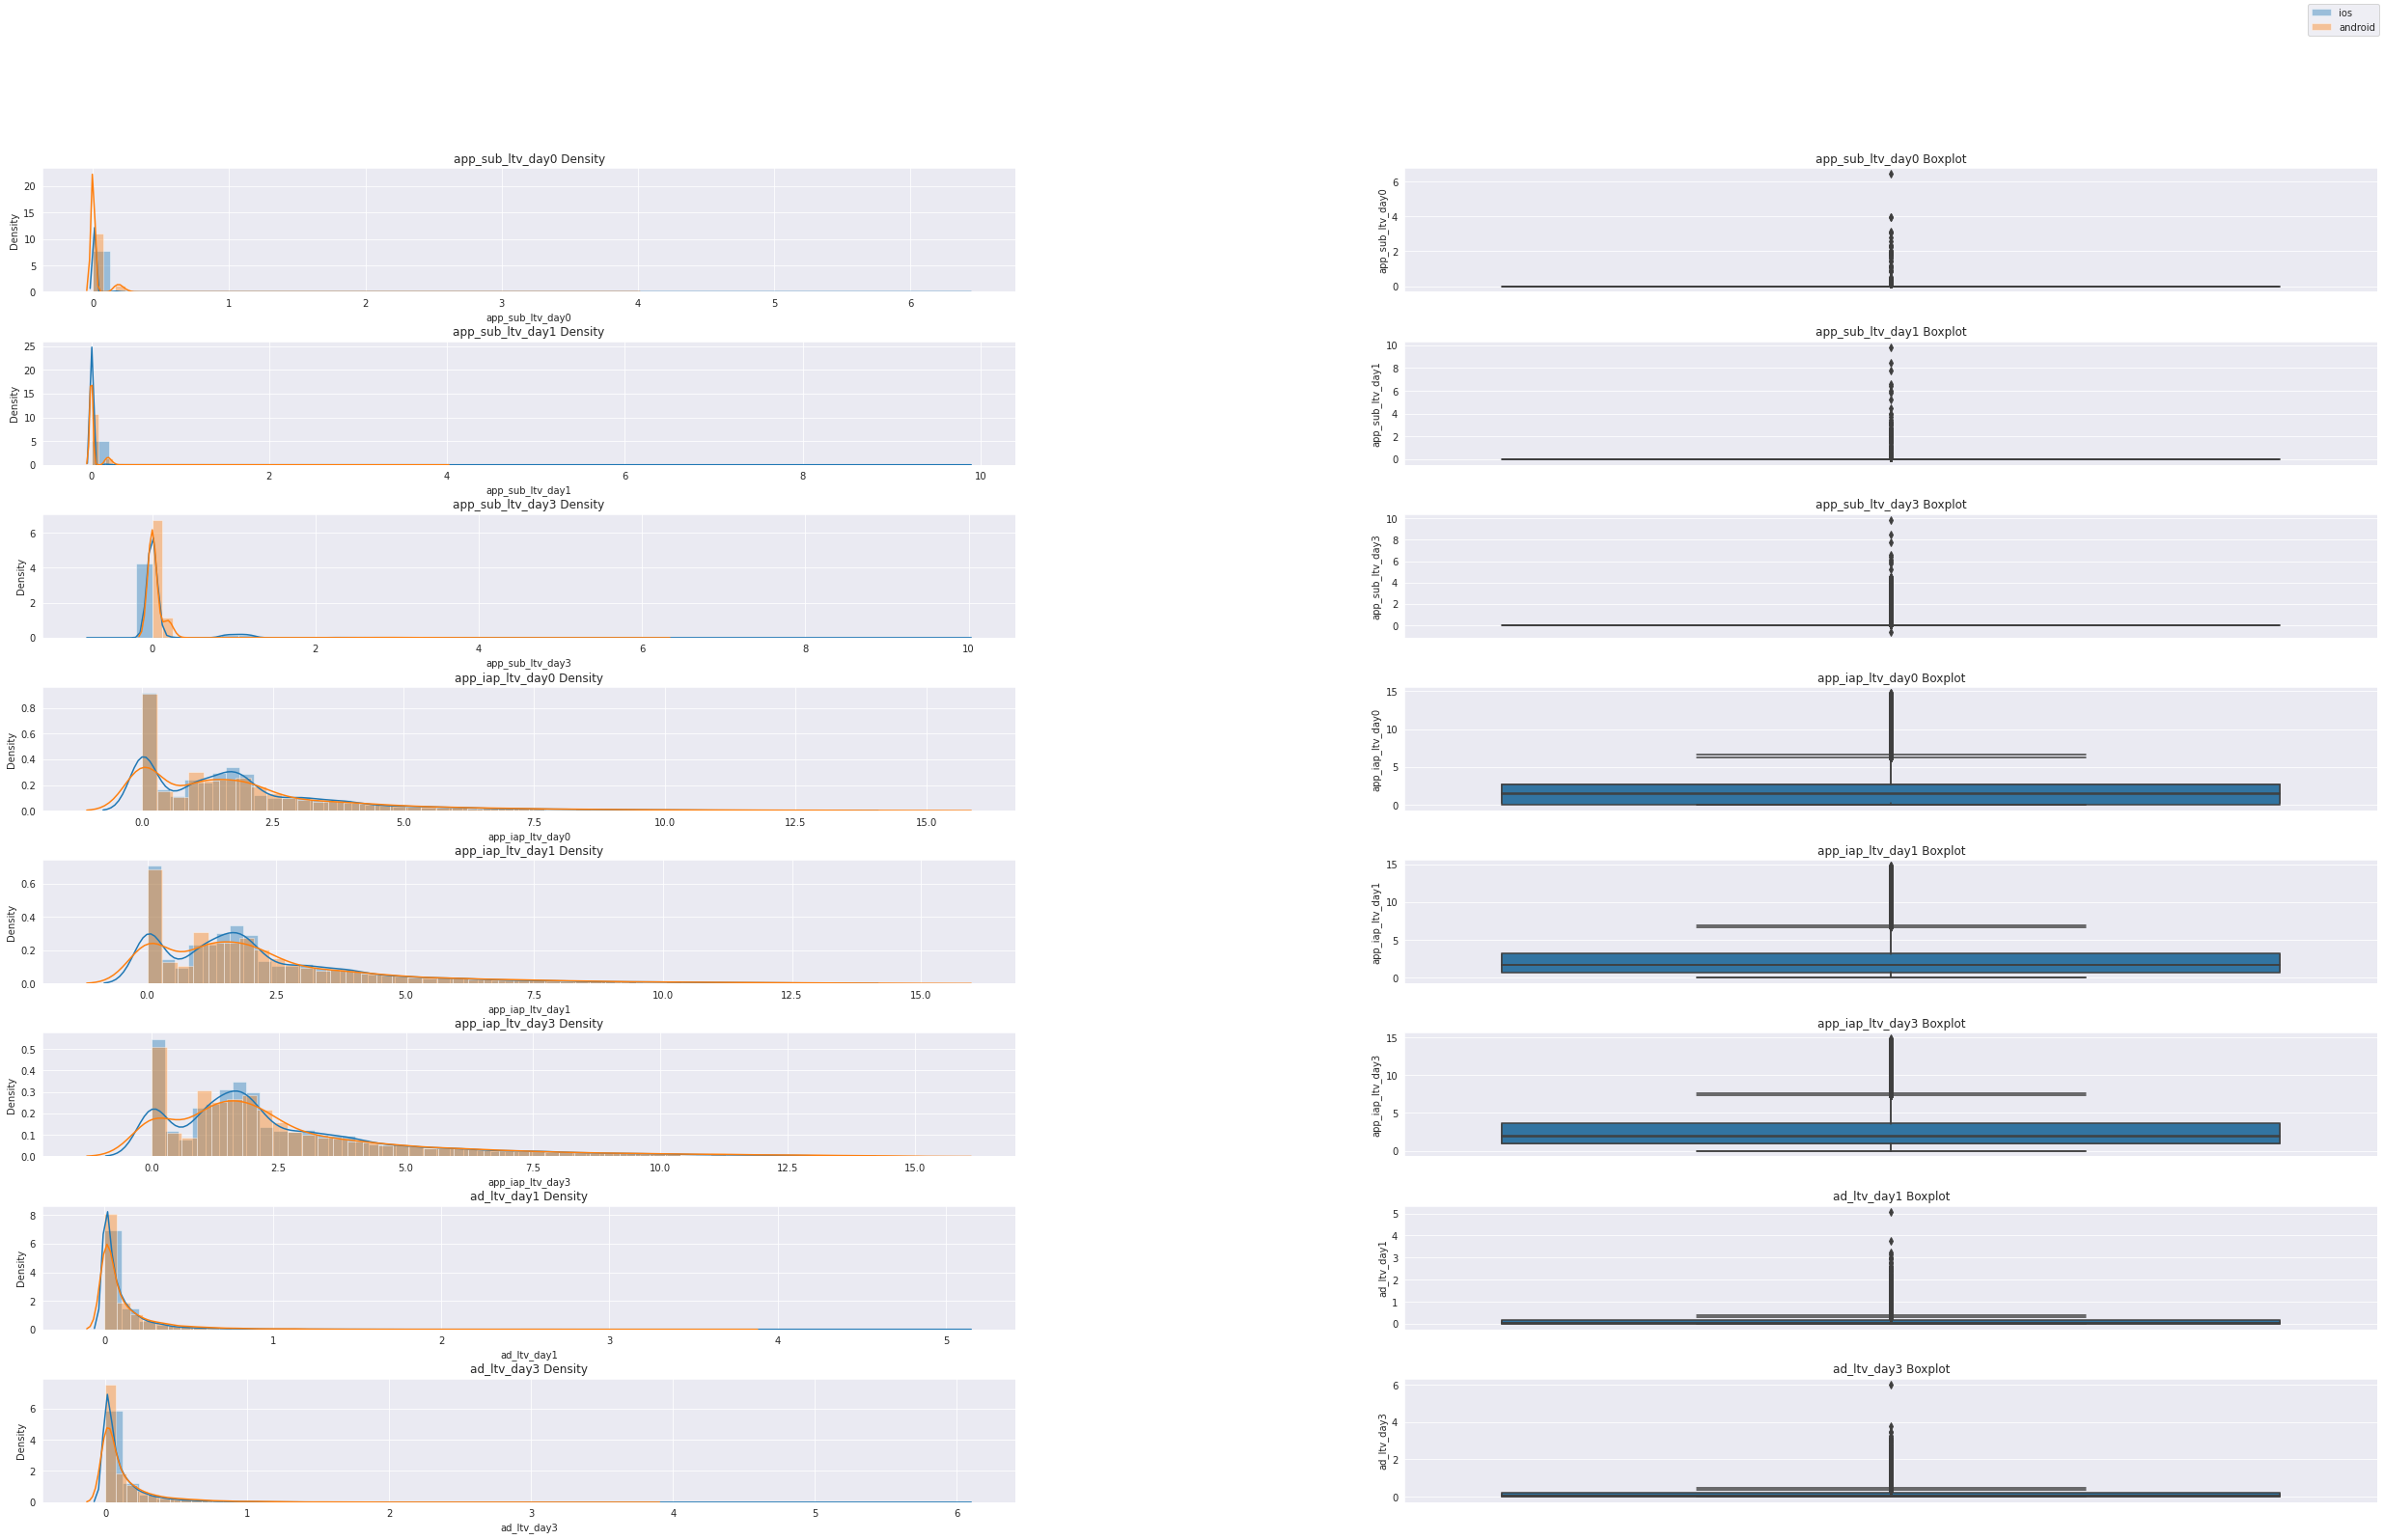

In [24]:
CUMULATIVE_INCOMES = ['app_sub_ltv_day0', 'app_sub_ltv_day1',
                 'app_sub_ltv_day3', 'app_iap_ltv_day0',
                 'app_iap_ltv_day1', 'app_iap_ltv_day3',
                 'ad_ltv_day1', 'ad_ltv_day3']

show_distribution(denoised_ios_df, denoised_android_df, CUMULATIVE_INCOMES)

It seems that distributions of the solvent users on both **IOS** and **Android** platforms are pretty **consistent**. There is no any reason to distinguish them based on Cumulative Incomes.

Let's take a look at **correlation of cumulative incomes**.

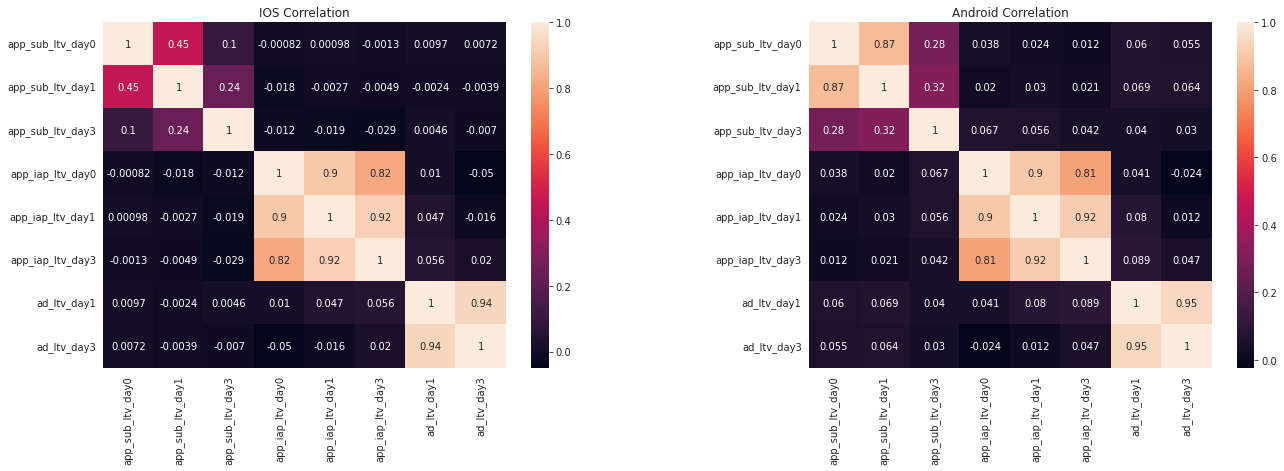

In [25]:
plot_heatmaps(denoised_ios_df, denoised_android_df, CUMULATIVE_INCOMES)

Here we may observe that three sources of cumulative incomes doesn't correlate with each other, however their inner features built based on day N do correlate. Therefore a good decision here is to take only highest day, since it represents cumulative incomes till the last day. In farther engineering steps we will replace them with their discrete values.

* **app_sub_ltv_day_3**
* **app_iap_ltv_day_3**
* **ad_ltv_day_3** 

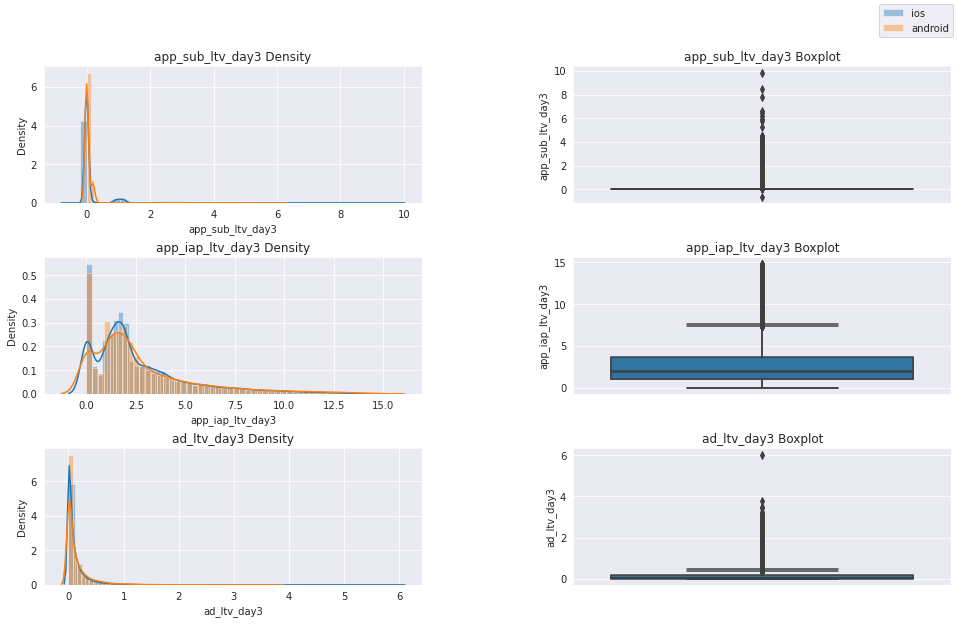

In [26]:
CUMULATIVE_INCOMES = ['app_sub_ltv_day3', 'app_iap_ltv_day3', 'ad_ltv_day3']

show_distribution(denoised_ios_df, denoised_android_df, CUMULATIVE_INCOMES)

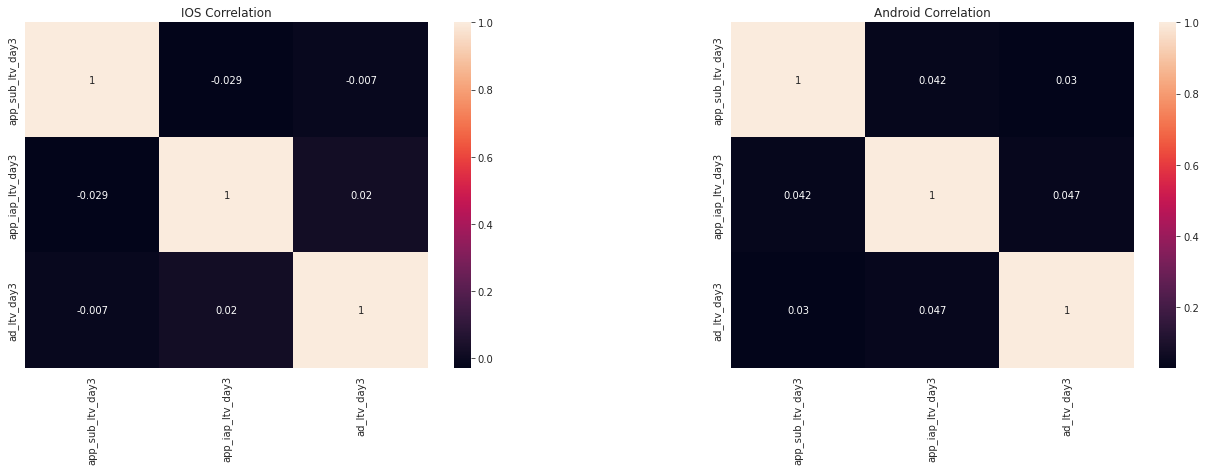

In [27]:
plot_heatmaps(denoised_ios_df, denoised_android_df, CUMULATIVE_INCOMES)

One more insight here is that for both IOS and Android platforms cumulative incomes from subscriptions and adverts are 0-centred. Thus, main source of the income is acquisition of gems and tickets.

### Top countries by **full_ltv_day30** <a class="anchor" name="top_countries_by_full_ltv_day30"></a>


Top 10 sum country_code based on target_full_ltv_day30 (IOS)
1. COUNTRY_141: 106306.68398285744
2. COUNTRY_155: 27794.177076901466
3. COUNTRY_72: 10809.56764725121
4. COUNTRY_38: 9245.99770394803
5. COUNTRY_204: 1414.9459889419275
6. COUNTRY_129: 1402.7525612923027
7. COUNTRY_23: 1199.151605268459
8. COUNTRY_26: 1052.9773334451027
9. COUNTRY_8: 954.1389147354114
10. COUNTRY_156: 887.1474079146855


Top 10 sum country_code based on target_full_ltv_day30 (Android)
1. COUNTRY_141: 25608.002332218977
2. COUNTRY_155: 11074.050742858073
3. COUNTRY_38: 2988.378694211115
4. COUNTRY_72: 2138.2981819810334
5. COUNTRY_35: 1147.5391064602045
6. COUNTRY_13: 818.628075009322
7. COUNTRY_156: 590.228124548439
8. COUNTRY_204: 376.7633938811535
9. COUNTRY_203: 332.73161010571056
10. COUNTRY_26: 319.3372471989414




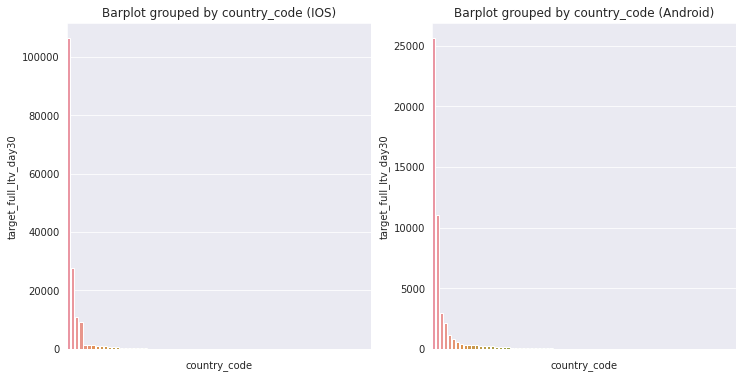

In [28]:
plot_hist_grouped_by(denoised_ios_df, denoised_android_df, 'country_code', TARGET)

Here we see that **COUNTRY_141** has much larger **full_ltv_day30** than other countries on both **IOS** and **Android** platform.

### Top media-sources by **full_ltv_day30** <a class="anchor" name="top_media_sources_by_full_ltv_day30"></a>

Top 10 sum media_source based on target_full_ltv_day30 (IOS)
1. SOURCE_17: 98398.2006531338
2. SOURCE_23: 46981.13145610852
3. SOURCE_4: 8276.590394664494
4. SOURCE_6: 3381.118771756601
5. SOURCE_5: 2681.680389626554
6. SOURCE_10: 1258.3910241570004
7. SOURCE_16: 1040.281736828694
8. SOURCE_18: 1035.6995260449992
9. SOURCE_1: 1020.1778715014714
10. SOURCE_12: 873.2709145405838


Top 10 sum media_source based on target_full_ltv_day30 (Android)
1. SOURCE_4: 26826.598620258035
2. SOURCE_2: 5382.334741841077
3. SOURCE_1: 4892.092449818124
4. SOURCE_17: 4856.104280868889
5. SOURCE_10: 3129.7798043496086
6. SOURCE_23: 2280.2684260952624
7. SOURCE_14: 631.2223056707966
8. SOURCE_19: 358.33708539666117
9. SOURCE_18: 129.450238955742
10. SOURCE_12: 48.938798675885735




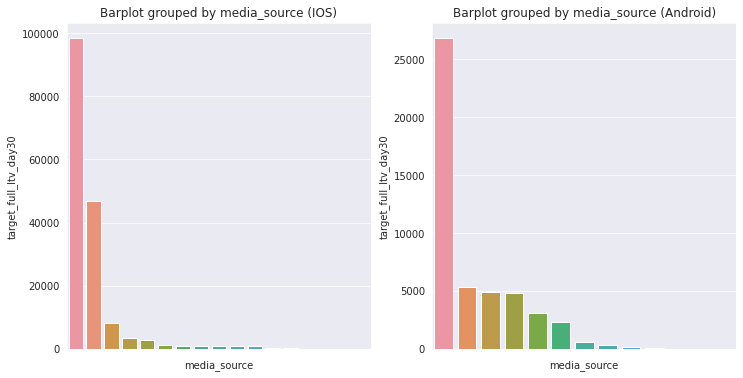

In [29]:
plot_hist_grouped_by(denoised_ios_df, denoised_android_df, 'media_source', TARGET)

**SOURCE_17** has the biggest impact on **IOS** traffic.

On the other hand, **SOURCE_4** fits **Android** platform the best.

## **Game currency** <a class="anchor" name="game_currency"></a>

Game currency in the dataset is represented by those cumulative variables:

* **tickets_spent_day**{N} 
* **diamonds_spent_day**{N} 
* **diamonds_received_day**{N} 

* **tickets_spent_session**{N} 
* **diamonds_spent_session**{N} 



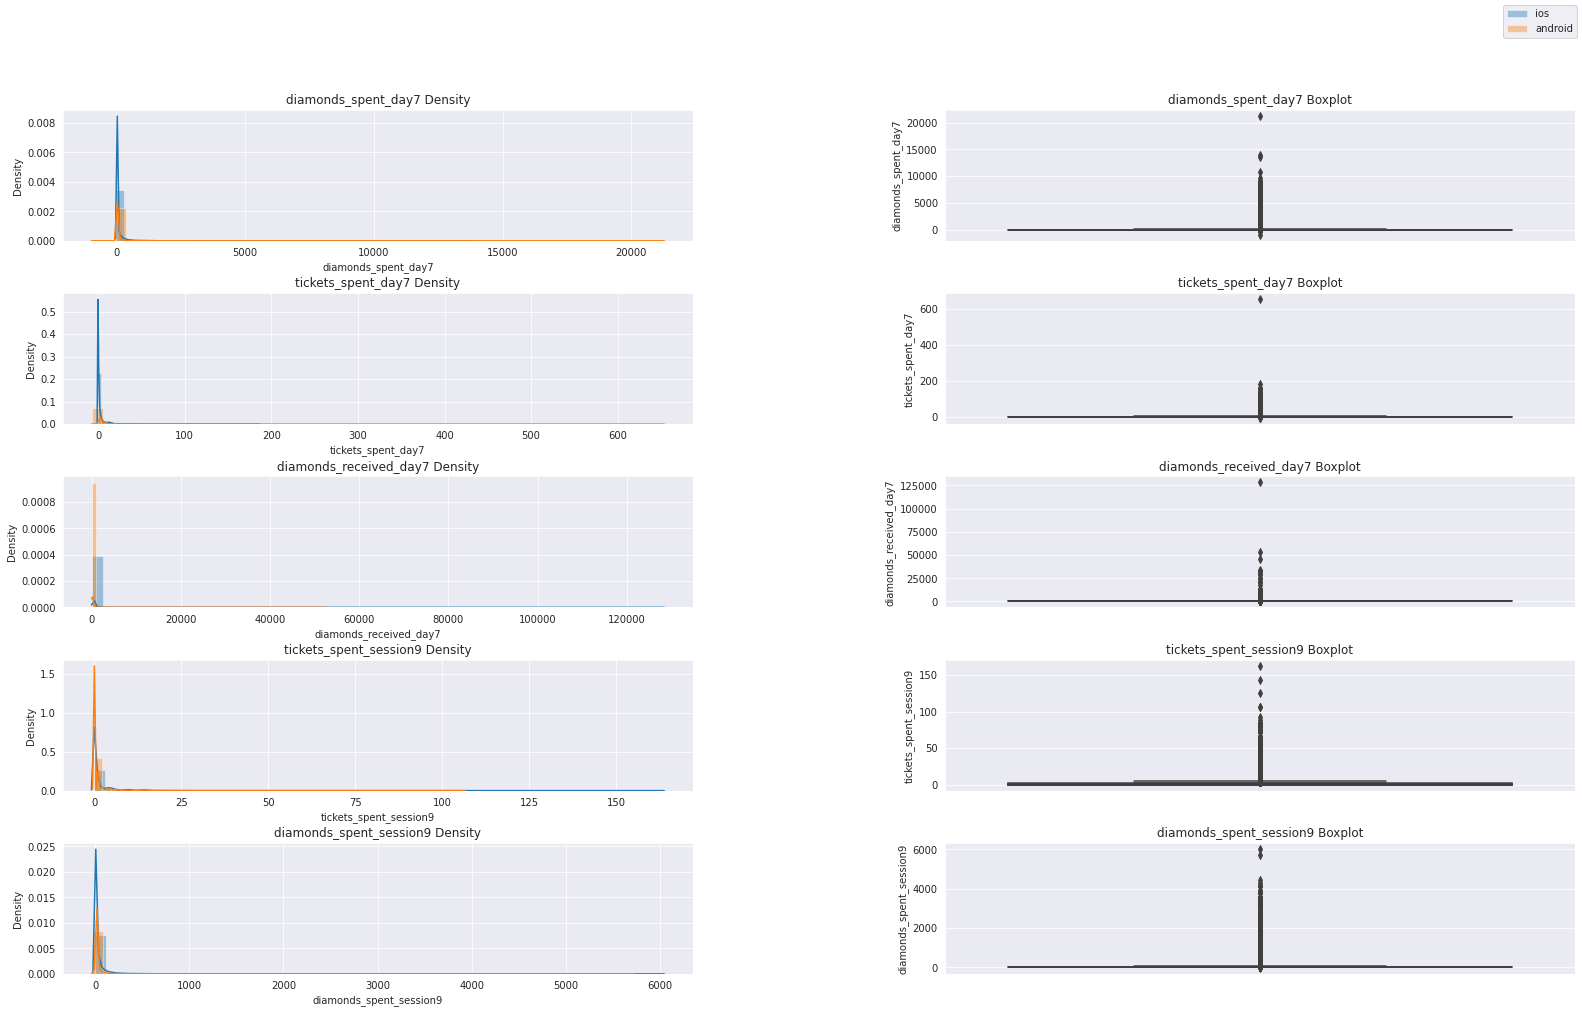

In [30]:
show_distribution(ios, android, ['diamonds_spent_day7', 'tickets_spent_day7', 'diamonds_received_day7', 'tickets_spent_session9', 'diamonds_spent_session9'])

From the above plots, we can see that the prevailing value in all distributions is **zero**, especially for **android users**, who are less active in using game currency. 

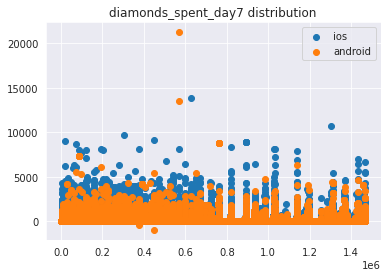

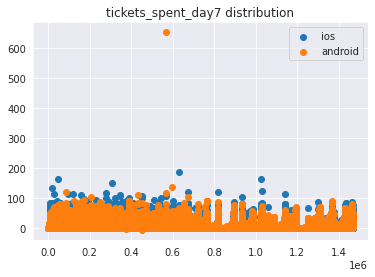

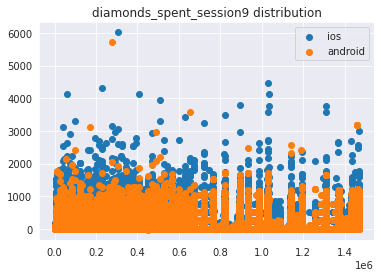

In [31]:
scatter_plt(df, 'platform', 'diamonds_spent_day7')
scatter_plt(df, 'platform', 'tickets_spent_day7')
scatter_plt(df, 'platform', 'diamonds_spent_session9')

In [32]:
describe_feature(android, ['diamonds_spent_day7', 'tickets_spent_day7', 'diamonds_received_day7', 'tickets_spent_session9', 'diamonds_spent_session9'])

,diamonds_received_day7,diamonds_spent_day7,tickets_spent_day7,diamonds_spent_session9,tickets_spent_session9
count,887426.000000,887426.000000,887426.000000,887426.000000,887426.000000
mean,32.083488,17.496152,1.046442,13.442366,0.910291
std,148.658807,89.549746,3.379913,48.733055,2.405607
min,0.000000,-955.000000,-7.000000,-29.000000,0.000000
25%,20.000000,0.000000,0.000000,0.000000,0.000000
50%,20.000000,0.000000,0.000000,0.000000,0.000000
75%,25.000000,12.000000,1.000000,12.000000,1.000000
max,52743.000000,21262.000000,653.000000,5718.000000,106.000000
var,8019.156947,11.423809,22099.440973,5.786946,2374.910681
zero_density,0.576112,0.697327,0.138437,0.692307,0.573484


Comment: **zero_density** varaible shows the proportion of values smaller than **0.2** in the distributions. It was created to find out the proportion of people who use more often game currency.

In [33]:
describe_feature(ios, ['diamonds_spent_day7', 'tickets_spent_day7', 'diamonds_received_day7', 'tickets_spent_session9', 'diamonds_spent_session9'])

,diamonds_received_day7,diamonds_spent_day7,tickets_spent_day7,diamonds_spent_session9,tickets_spent_session9
count,580406.000000,580406.000000,580406.000000,580406.000000,580406.000000
mean,69.238159,51.952566,2.162295,37.733118,1.810641
std,261.868634,185.395974,5.160915,109.563248,3.652384
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,0.000000,0.000000,0.000000,0.000000
50%,22.000000,12.000000,0.000000,12.000000,0.000000
75%,33.000000,24.000000,2.000000,24.000000,2.000000
max,128354.000000,13893.000000,185.000000,6021.000000,163.000000
var,34371.667131,26.635042,68575.181521,13.339908,12004.105319
zero_density,0.395813,0.547563,0.060680,0.540232,0.390735


Summing up we can say that ios users are more able to invest money in the game rather than people that use the android platform. We can see that from scatter plots and descriptive statistics. For example, ios users have more high variance and mean distribution values. Also, the density of zero value is higher for android users, so they spend less money on tickets, and diamonds and as a result, they don`t use them a lot. This difference is better seen in the distributions of spent or received diamonds rather than in the tickets.


### Anomaly detection <a class="anchor" name="anomaly_detection"></a>

Distributions of **diamonds_spent_day**, **tickets_spent_day** and **diamonds_spent_session** contained some negative values, which were anomalies. 

In [34]:
# recognition of anomalies
df = handle_negative(df, ['diamonds_spent_day7', 'diamonds_received_day7', 'tickets_spent_day7', 'tickets_spent_session9', 'diamonds_spent_session9'])

# removal of anomalies 
df = handle_negative(df, ['diamonds_spent_day7', 'diamonds_received_day7', 'tickets_spent_day7', 'tickets_spent_session9', 'diamonds_spent_session9'], flag = True) 

374828   -364
449835   -955
Name: diamonds_spent_day7, dtype: int64
Series([], Name: diamonds_received_day7, dtype: int64)
374828   -4
449835   -7
Name: tickets_spent_day7, dtype: int64
Series([], Name: tickets_spent_session9, dtype: int64)
449835   -29
Name: diamonds_spent_session9, dtype: int64


In [35]:
df = handle_negative(df, ['diamonds_spent_day7', 'diamonds_received_day7', 'tickets_spent_day7', 'tickets_spent_session9', 'diamonds_spent_session9'])

ios = df.loc[df['platform'] == 'ios']
android = df.loc[df['platform'] == 'android']


Series([], Name: diamonds_spent_day7, dtype: int64)
Series([], Name: diamonds_received_day7, dtype: int64)
Series([], Name: tickets_spent_day7, dtype: int64)
Series([], Name: tickets_spent_session9, dtype: int64)
Series([], Name: diamonds_spent_session9, dtype: int64)


### Correlation plots <a class="anchor" name="correlation_plots"></a>

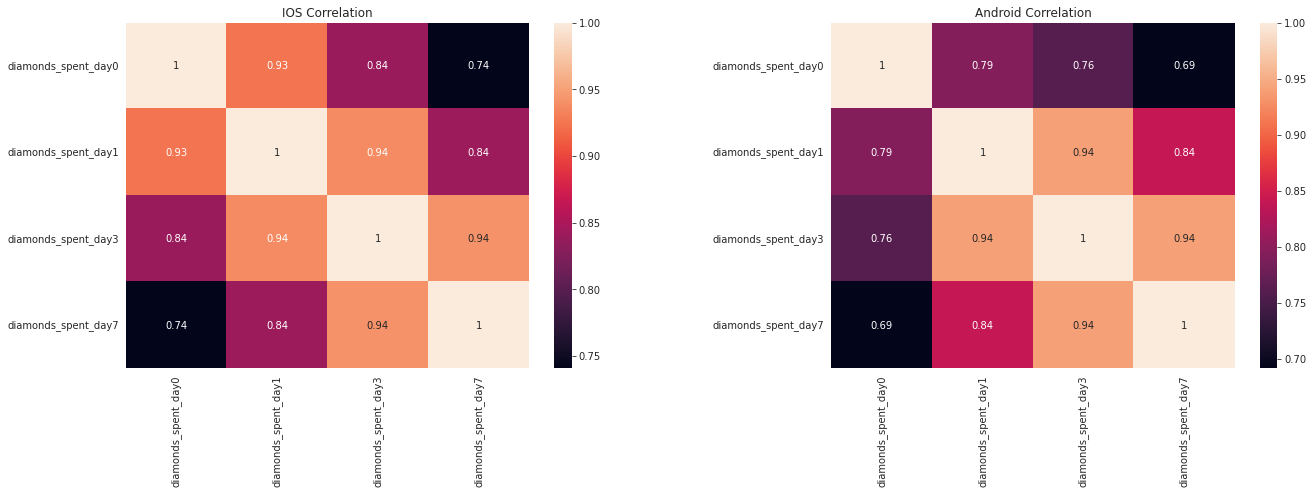

In [36]:
plot_heatmaps(ios, android, ['diamonds_spent_day0', 'diamonds_spent_day1', 'diamonds_spent_day3', 'diamonds_spent_day7'])

Comment: the closer days are to each other the higher is correlation between them. For example variables **diamonds_spent_day3** and **diamonds_spent_day7** are more correlated rather then **diamonds_spent_day1** and **diamonds_spent_day7**. 

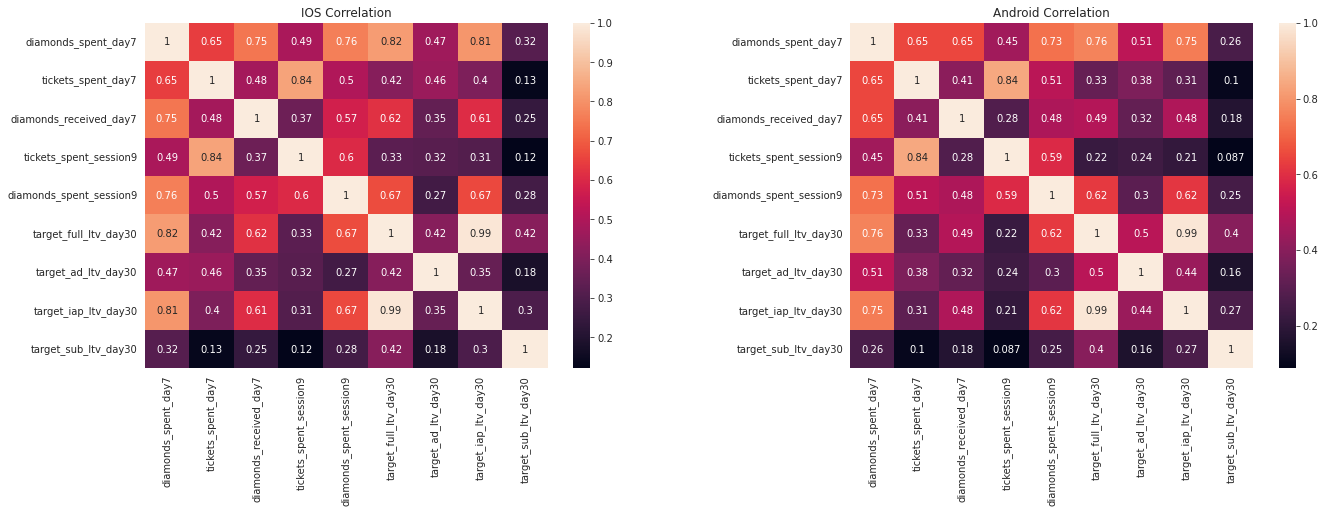

In [37]:
plot_heatmaps(ios, android, ['diamonds_spent_day7', 'tickets_spent_day7', 'diamonds_received_day7', 'tickets_spent_session9', 'diamonds_spent_session9','target_full_ltv_day30', 'target_ad_ltv_day30', 'target_iap_ltv_day30', 'target_sub_ltv_day30'])

From above heatmaps we see that variables related to diamonds are more correlated with the target variable (**target_full_ltv_day30**).

### Categorical varaibles and currency <a class="anchor" name="categorical_varaibles_and_currency"></a>

In [38]:
top_idx_country = select_top_n(df, 'country_code', 'diamonds_spent_day7', 10)
top_idx_media = select_top_n(df, 'media_source', 'diamonds_spent_day7', 5)
df = merge_unpopular_categories(df, 'country_code', top_idx_country.values)
df = merge_unpopular_categories(df, 'media_source', top_idx_media.values)


ios = df.loc[df['platform'] == 'ios']
android = df.loc[df['platform'] == 'android']

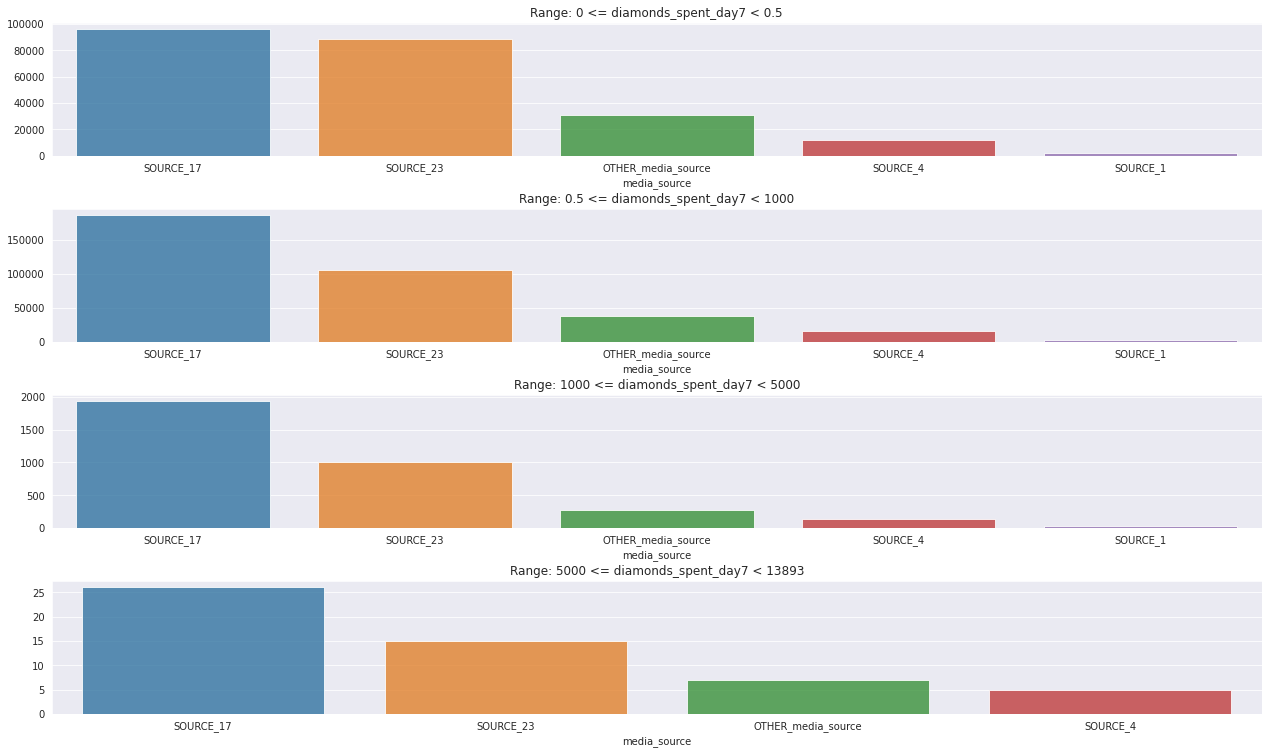

In [39]:
category_range(ios, [(0, 0.5), (0.5, 1000), (1000, 5000), (5000, ios['diamonds_spent_day7'].max())], 'diamonds_spent_day7', 'media_source')

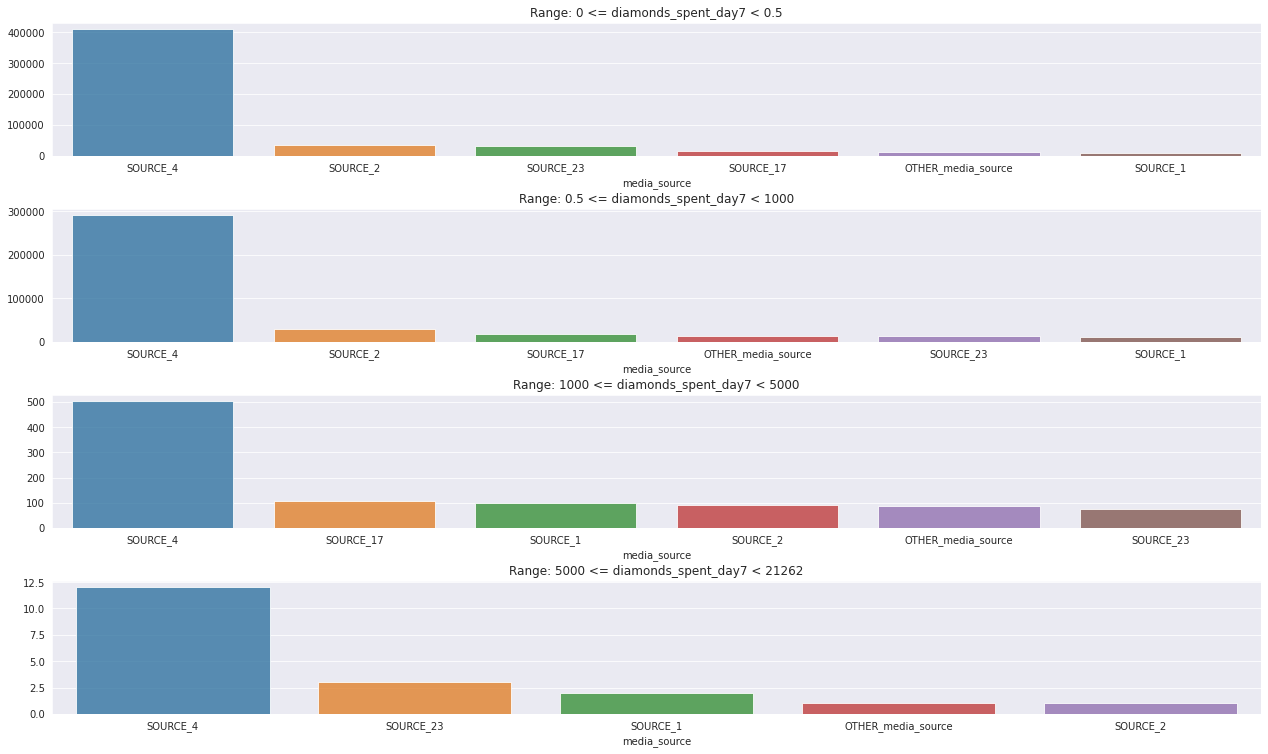

In [40]:
category_range(android, [(0, 0.5), (0.5, 1000), (1000, 5000), (5000, android['diamonds_spent_day7'].max())], 'diamonds_spent_day7', 'media_source')

It was decided to split all values that feature takes into several diapasons in order to look in what ranges what countries or media sources prevail for different platforms. As we see, for android the dominant media source is **source_4**, while for ios it's **source_17**. Also, in the higher value diapasons android appears less often in comparison with the ios platform.

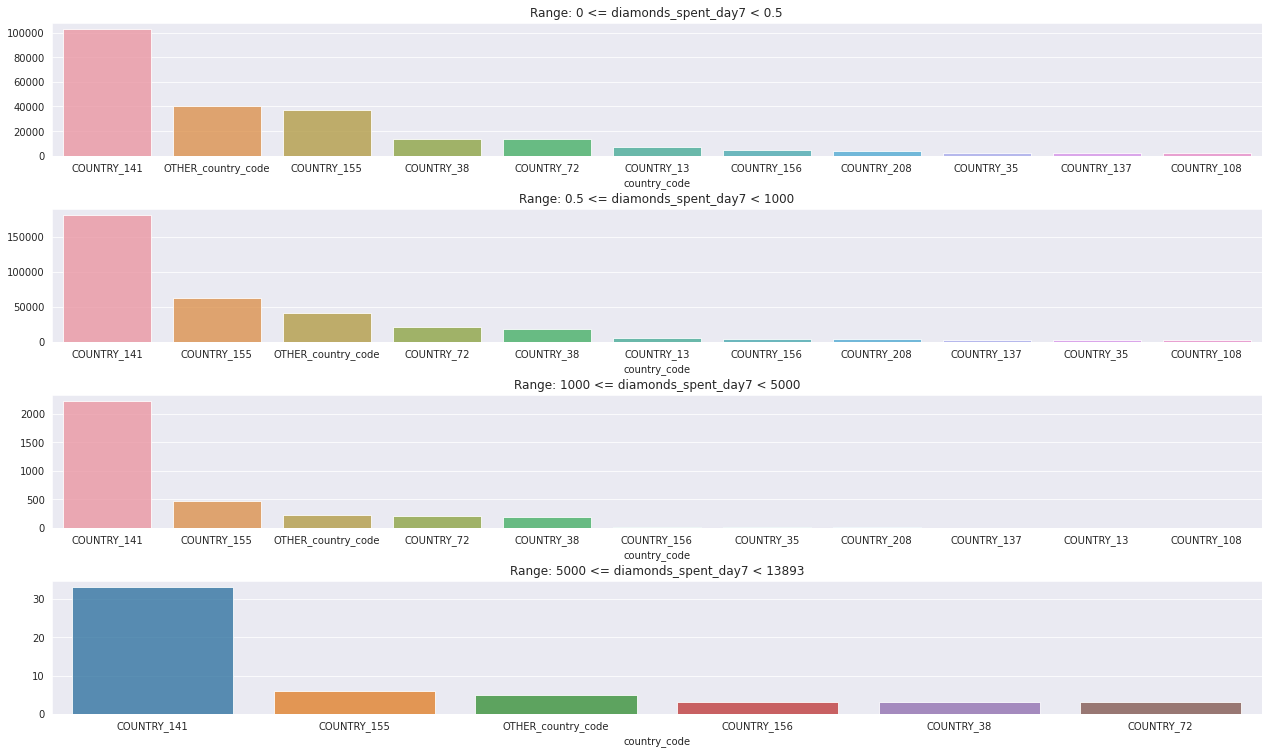

In [41]:
category_range(ios, [(0, 0.5), (0.5, 1000), (1000, 5000), (5000, ios['diamonds_spent_day7'].max())], 'diamonds_spent_day7', 'country_code')

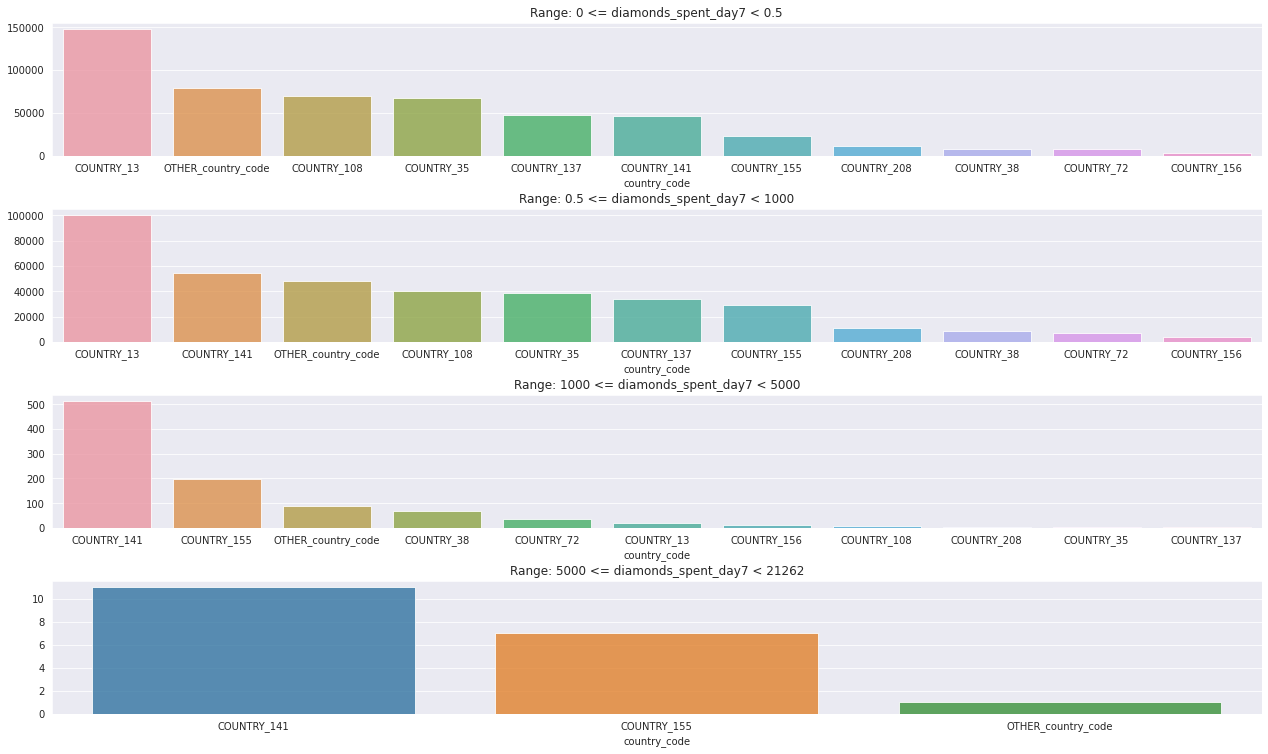

In [42]:
category_range(android, [(0, 0.5), (0.5, 1000), (1000, 5000), (5000, android['diamonds_spent_day7'].max())], 'diamonds_spent_day7', 'country_code')

For android there are two dominant country indexes: for the lower value diapason it's **country_13** and for the higher, it's **country_141**. The situation with ios is different, it has only one prevailing country index: **country_141**. Also, the ios platform has a wider range of unique country indexes that are present in higher value diapasons.

### Correlation maps for discrete variables <a class="anchor" name="correlation_maps_for_discrete_variables"></a>


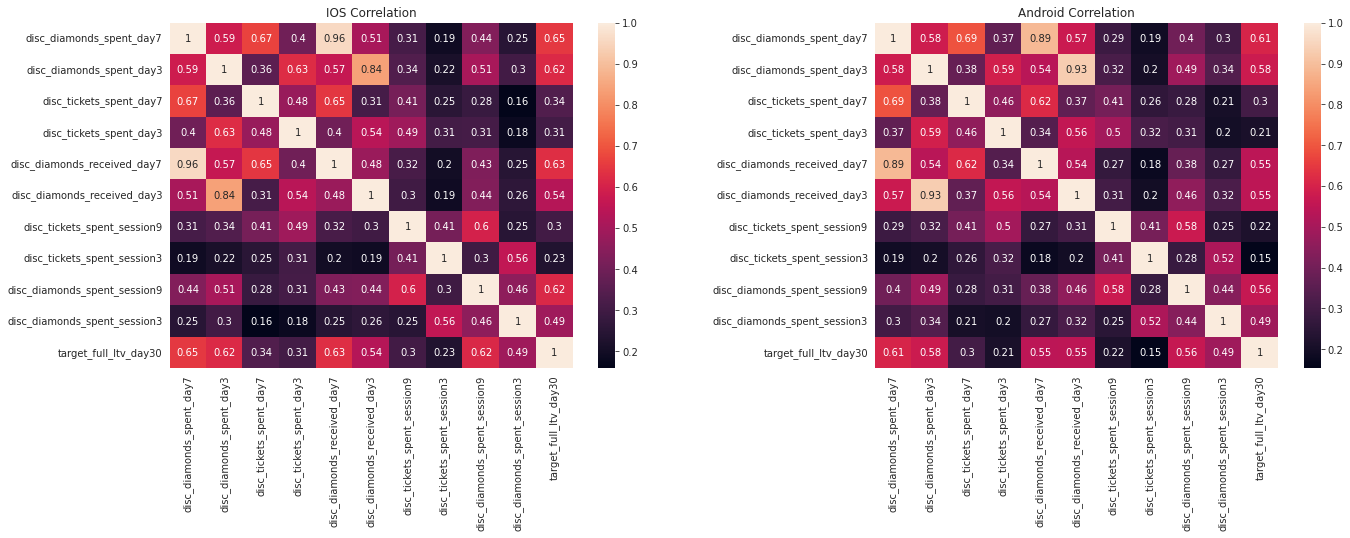

In [43]:
mdf_df = transform_all_cumulative(df, ['diamonds_received_day', 'diamonds_spent_day', 'tickets_spent_day', 'tickets_spent_session', 'diamonds_spent_session'])

ios = mdf_df.loc[df['platform'] == 'ios']
android = mdf_df.loc[mdf_df['platform'] == 'android']
plot_heatmaps(ios, android, ['disc_diamonds_spent_day7', 'disc_diamonds_spent_day3', 
                             'disc_tickets_spent_day7', 'disc_tickets_spent_day3', 
                             'disc_diamonds_received_day7', 'disc_diamonds_received_day3', 
                             'disc_tickets_spent_session9', 'disc_tickets_spent_session3', 
                             'disc_diamonds_spent_session9', 'disc_diamonds_spent_session3', 
                             'target_full_ltv_day30'])

After transforming all cumulative variables into the discrete correlation between features become smaller. Also, as before we see that variables related to diamonds are more correlated with the target variable rather than those with information about tickets. 

## Activity 1 <a class="anchor" name="activity_1"></a>
In this section following metrics will be analyzed: \
total_sessions_day{N} \
chapters_finished_session{N} \
chapters_opened_session{N} \
chapters_closed_session{N} \


### Cumulative values <a class="anchor" name="cumulative_values"></a>

In [44]:
act_cols = ['total_sessions_day', 'chapters_finished_session', 'chapters_opened_session', 'chapters_closed_session']
act_cum_cols = [col for feature in act_cols for col in get_target_columns(df, feature)]
act_cum_cols

['total_sessions_day0',
 'total_sessions_day1',
 'total_sessions_day3',
 'total_sessions_day7',
 'chapters_finished_session1',
 'chapters_finished_session3',
 'chapters_finished_session9',
 'chapters_opened_session1',
 'chapters_opened_session3',
 'chapters_opened_session9',
 'chapters_closed_session1',
 'chapters_closed_session3',
 'chapters_closed_session9']

In [45]:
last_day_cum_cols = ['total_sessions_day7', 'chapters_finished_session9','chapters_opened_session9','chapters_closed_session9']
df[last_day_cum_cols].describe()

,total_sessions_day7,chapters_finished_session9,chapters_opened_session9,chapters_closed_session9
count,1.467830e+06,1.467830e+06,1.467830e+06,1.467830e+06
mean,3.110491e+00,1.664425e+00,2.584893e+00,4.535082e-01
std,7.884697e+00,4.135931e+00,4.284710e+00,1.523383e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
50%,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
75%,2.000000e+00,1.000000e+00,2.000000e+00,0.000000e+00
max,9.050000e+02,2.790000e+02,2.930000e+02,1.990000e+02


In [46]:
denoised_ios_df[last_day_cum_cols].describe()

,total_sessions_day7,chapters_finished_session9,chapters_opened_session9,chapters_closed_session9
count,42831.000000,42831.000000,42831.000000,42831.000000
mean,12.420793,8.768415,9.772174,1.607924
std,20.575268,7.627686,7.865076,3.440834
min,0.000000,0.000000,0.000000,0.000000
25%,3.000000,3.000000,4.000000,0.000000
50%,6.000000,7.000000,8.000000,1.000000
75%,13.000000,12.000000,13.000000,2.000000
max,711.000000,237.000000,259.000000,186.000000


In [47]:
denoised_android_df[last_day_cum_cols].describe()

,total_sessions_day7,chapters_finished_session9,chapters_opened_session9,chapters_closed_session9
count,11691.000000,11691.000000,11691.000000,11691.000000
mean,12.807972,8.434608,9.369772,1.590112
std,21.535587,7.634781,7.751246,3.586113
min,0.000000,0.000000,0.000000,0.000000
25%,3.000000,3.000000,4.000000,0.000000
50%,6.000000,6.000000,7.000000,1.000000
75%,13.000000,12.000000,13.000000,2.000000
max,405.000000,264.000000,270.000000,199.000000


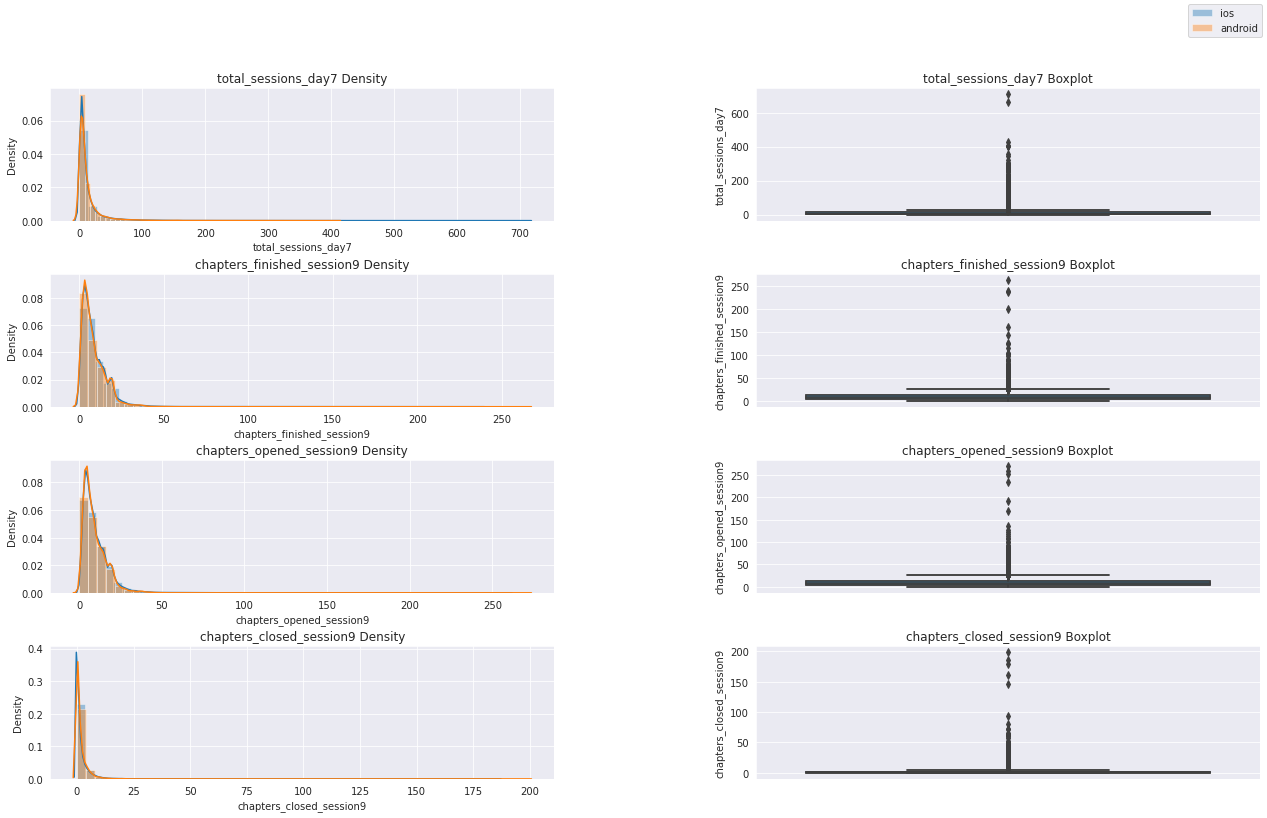

In [48]:
show_distribution(denoised_ios_df, denoised_android_df, last_day_cum_cols)

Comment: from the plots above it can be seen that distributions of `chapters_opened_session9` and `chapters_finished_session9` are quite similar which makes sense. It would be interesting to examine distributions more closely.
What about `total_sessions_day7`. Distributions seem to also be similar, however IOS platform has more outliers.

In [49]:
def percentage_of_column(df, nom, denom):
  perc = df[nom].median() / df[denom].median()
  return perc

In [50]:
print('IOS')
print(percentage_of_column(denoised_ios_df, 'chapters_finished_session9', 'chapters_opened_session9'))

print('IOS')
print(percentage_of_column(denoised_android_df, 'chapters_finished_session9', 'chapters_opened_session9'))

IOS
0.875
IOS
0.8571428571428571


In [51]:
sign_denoised_ios = denoised_ios_df[denoised_ios_df['total_sessions_day7'] < 50]
sign_denoised_android= denoised_android_df[denoised_android_df['total_sessions_day7'] < 50]

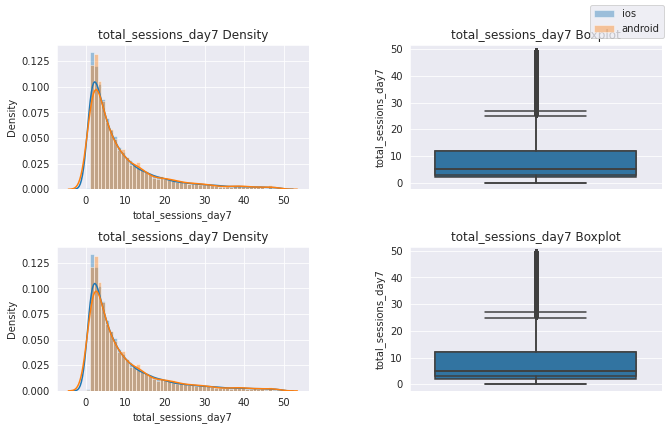

In [52]:
show_distribution(sign_denoised_ios, sign_denoised_android, ['total_sessions_day7', 'total_sessions_day7'])
# two rows are the same  same thing (it should be like this :)

Comment: after closer look once again at denoised distributions we see that they are similar.

### Comparing discrete values <a class="anchor" name="comparing_discrete_values"></a>
To analyze tendencies in next paragraph we will make metrics discrete according to period (e.g `disc_total_session7` show number of sessions in period from day 4 to day 7 inclusive)

In [53]:
denoised_disc_ios_df = transform_all_cumulative(denoised_ios_df, act_cols)
denoised_disc_android_df = transform_all_cumulative(denoised_android_df, act_cols)
act_disc_cols = [f'disc_{i}' for i in act_cum_cols]

In [54]:
ios_avg_sessions = denoised_disc_ios_df[act_disc_cols].mean() 
android_avg_sessions = denoised_disc_android_df[act_disc_cols].mean()

In [55]:
act_disc_cols

['disc_total_sessions_day0',
 'disc_total_sessions_day1',
 'disc_total_sessions_day3',
 'disc_total_sessions_day7',
 'disc_chapters_finished_session1',
 'disc_chapters_finished_session3',
 'disc_chapters_finished_session9',
 'disc_chapters_opened_session1',
 'disc_chapters_opened_session3',
 'disc_chapters_opened_session9',
 'disc_chapters_closed_session1',
 'disc_chapters_closed_session3',
 'disc_chapters_closed_session9']

In [56]:
def discerete_to_days(ser):
  ser = ser.copy()
  ser.loc['disc_total_sessions_day3'] /= 2
  ser.loc['disc_total_sessions_day7'] /= 4
  ser.loc['disc_chapters_finished_session3'] /= 2
  ser.loc['disc_chapters_finished_session9'] /= 6
  ser.loc['disc_chapters_opened_session3'] /= 2
  ser.loc['disc_chapters_opened_session9'] /= 6
  ser.loc['disc_chapters_closed_session3'] /= 2
  ser.loc['disc_chapters_closed_session9'] /= 6
  return ser


In [57]:
def plot_series(ios, android):
  ax = ios.T.plot(label='ios')
  android.T.plot(ax=ax, label='android')
  plt.xticks(rotation=90)
  plt.legend()


In [58]:
disc_to_days_ios = discerete_to_days(ios_avg_sessions)
disc_to_days_android = discerete_to_days(android_avg_sessions)

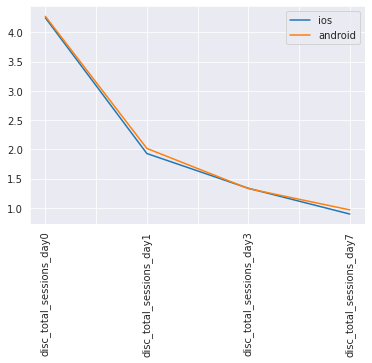

In [59]:
plot_series(disc_to_days_ios[:4], disc_to_days_android[:4])

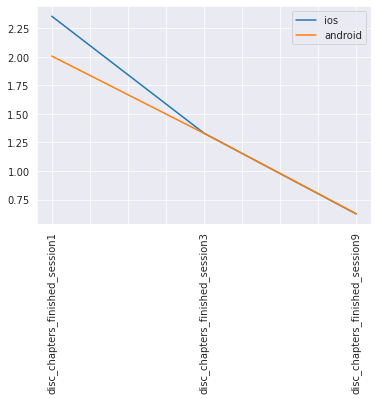

In [60]:
plot_series(disc_to_days_ios[4:7], disc_to_days_android[4:7])

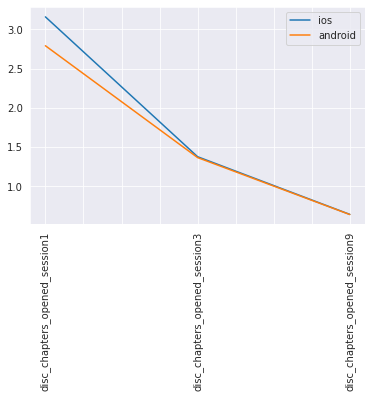

In [61]:
plot_series(disc_to_days_ios[7:10], disc_to_days_android[7:10])

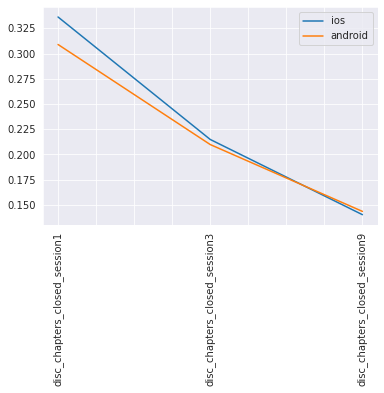

In [62]:
plot_series(disc_to_days_ios[10:13], disc_to_days_android[10:13])

In [63]:
abs(disc_to_days_ios - disc_to_days_android)

disc_total_sessions_day0           0.025919
disc_total_sessions_day1           0.087151
disc_total_sessions_day3           0.005479
disc_total_sessions_day7           0.071267
disc_chapters_finished_session1    0.348219
disc_chapters_finished_session3    0.001165
disc_chapters_finished_session9    0.002790
disc_chapters_opened_session1      0.368016
disc_chapters_opened_session3      0.011075
disc_chapters_opened_session9      0.002039
disc_chapters_closed_session1      0.027249
disc_chapters_closed_session3      0.005037
disc_chapters_closed_session9      0.003252
dtype: float64

Comment: The difference between platforms is noticed in user interaction with chapters in the fist couple of days. The difference itself seems not significant. However, it is worth mentioning that we don't have any information about the duration of sessions or about the size of a chapter, thus interpretation may change provided such information.

 `total_sessions` per day is almost the same in two platforms.

 To summarize, it seems that IOS users are more intersted in content on average.

### Correlation analysis <a class="anchor" name="correlation_analysis"></a>

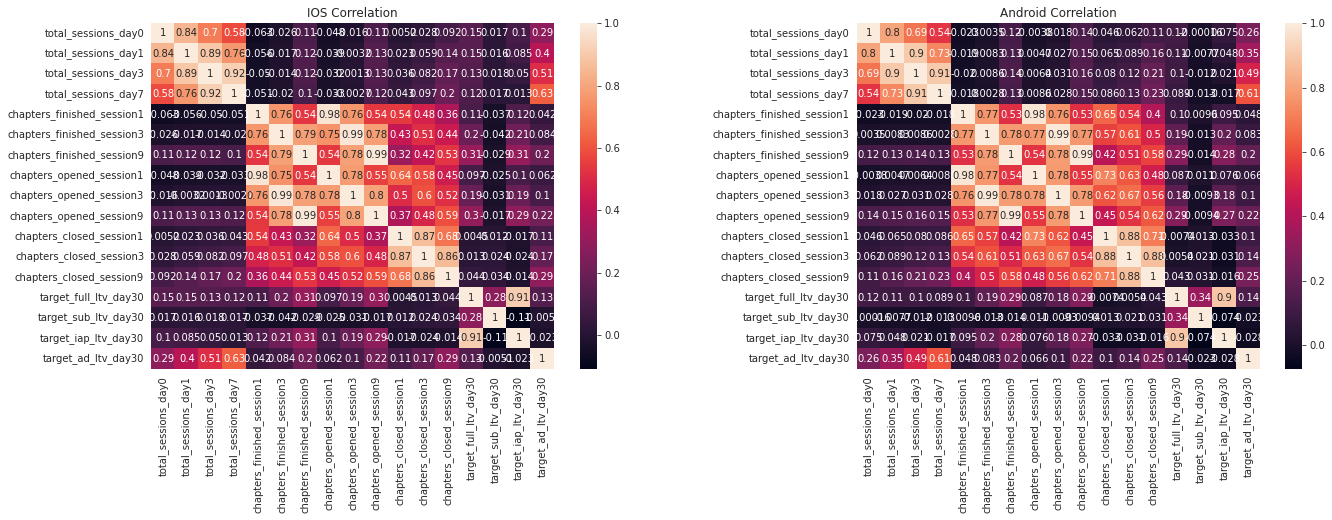

In [64]:
plot_heatmaps(denoised_ios_df, denoised_android_df, act_cum_cols + [TARGET] + SUBTARGETS)

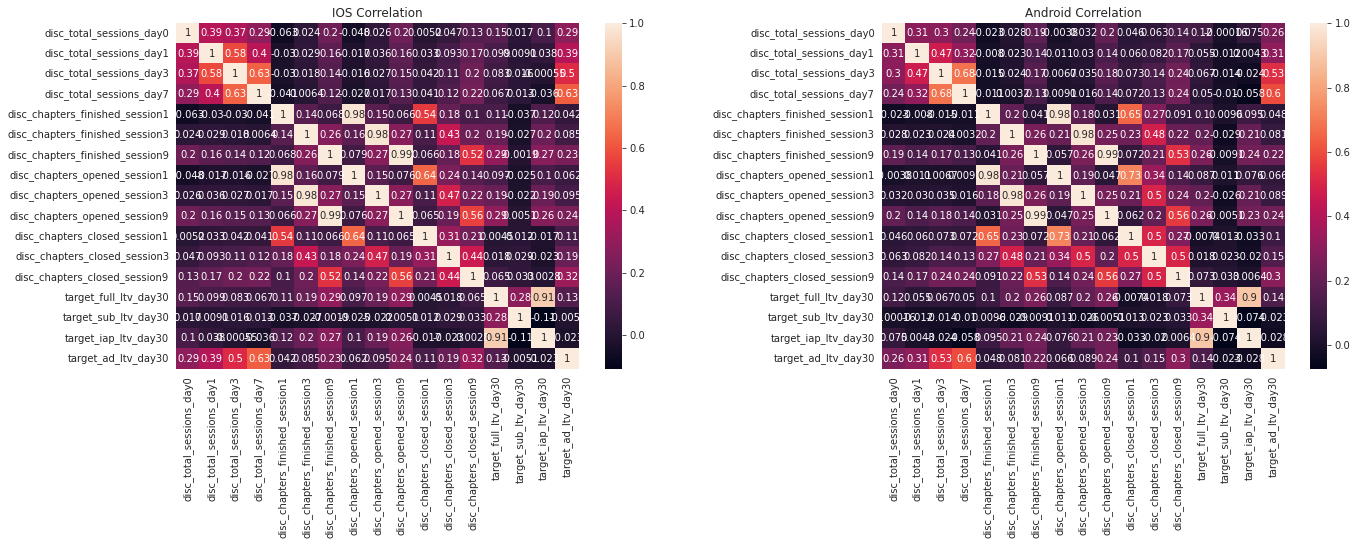

In [65]:
plot_heatmaps(denoised_disc_ios_df, denoised_disc_android_df, act_disc_cols + [TARGET] + SUBTARGETS)

Comment: Correlations maps of discrete and cumulative metrics are quite similar. For further analysis discrete mertics are taken.

Correlation between `chapter_finished`, `chapter_closed`, `chapter_opened` is self explenatory

`total_sesions` correlate wtih `target_ad_ltv_day30`. Interpretation: the more sessions user spents in app, the more ads he sees, however is does not influece other types of revenue significantly.

`disc_chapters_finished_session9` correlates with `target_iap_ltv_day30`, `target_ad_ltv_day30`



In [66]:
selected_columns = [
    'disc_total_sessions_day0',
 'disc_total_sessions_day1',
 'disc_total_sessions_day3',
 'disc_total_sessions_day7',
 'disc_chapters_finished_session9',
]

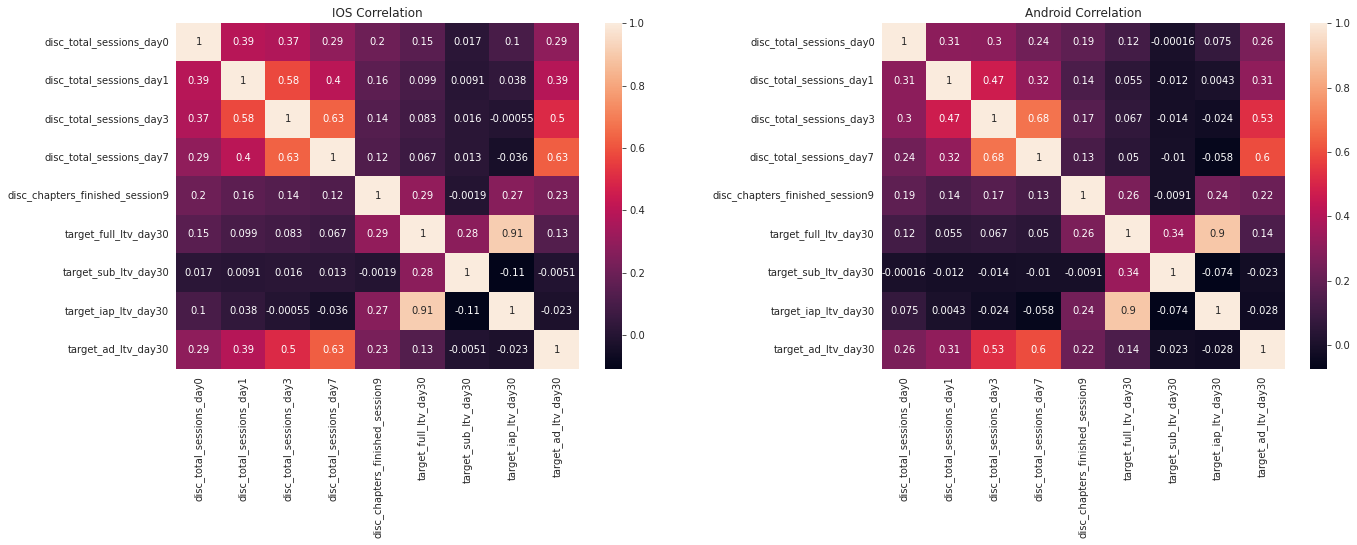

In [67]:
plot_heatmaps(denoised_disc_ios_df, denoised_disc_android_df, selected_columns + [TARGET] + SUBTARGETS)

## **Activity 2** <a class="anchor" name="activity_2"></a>

### Additional plot utils <a class="anchor" name="additional_plot_utils"></a>

In [68]:
def show_dis_by_group(df, group_feature, features, features_type='cont', fig_title='Figure'):
    n = len(features)
    fig, axes = plt.subplots(nrows=n, ncols=1, figsize=(1*5, n*5))
    fig.suptitle(fig_title)

    for i, feature in enumerate(features):
        ax = axes[i]
        
        if features_type == 'cont':
            sns.histplot(df, x=feature, hue=group_feature, ax=ax, element="step", bins=50, kde=True)
        elif features_type == 'cat':
            sns.histplot(df, x=feature, hue=group_feature, ax=ax, discrete=True, shrink=0.8, kde=True)

        ax.set_title(f'{feature} Histogram')
        ax.tick_params(axis='x', labelrotation=-90)

    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=1.5, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.4)
    
    plt.show()

def ord_by_split(df, split_feat, bounds, choices=[0, 1, 2, 3]):
    lower_bound = bounds[0]
    middle_bound = bounds[1]
    upper_bound = bounds[2]
    print(lower_bound, middle_bound, upper_bound)
    conditions = [
        df[split_feat] <= lower_bound,
        df[split_feat].between(lower_bound, middle_bound, inclusive='right'),
        df[split_feat].between(middle_bound, upper_bound, inclusive='right'),
        df[split_feat] > upper_bound
    ]
    return np.select(conditions, choices)

### Dataset preparation <a class="anchor" name="dataset_preparation"></a>

In [69]:
cat_cols = ['media_source', 'country_code', 'platform'] + [f'retained_day{i}' for i in [7]]
time_cols = ['install_date']
num_cols = [f'chapters_finished_day{i}' for i in [7]] + \
[f'chapters_opened_day{i}' for i in [7]]

In [70]:
act2_df = df[cat_cols + time_cols + num_cols]

In [71]:
act2_df['activity'] = ord_by_split(act2_df, 'chapters_opened_day7', [2, 6, 32])
act2_df.tail()

2 6 32


,media_source,country_code,platform,retained_day7,install_date,chapters_finished_day7,chapters_opened_day7,activity
1467827,SOURCE_17,COUNTRY_141,ios,0,2021-12-30,9,10,2
1467828,SOURCE_23,COUNTRY_141,ios,0,2021-12-30,13,13,2
1467829,SOURCE_23,COUNTRY_141,ios,0,2021-12-30,18,19,2
1467830,SOURCE_4,COUNTRY_141,ios,0,2021-12-30,24,24,2
1467831,SOURCE_1,COUNTRY_141,android,0,2021-12-30,15,16,2


Splitted users in less or more active based on how many chapters they opened till 7 day.

### Distributions <a class="anchor" name="distributions"></a>

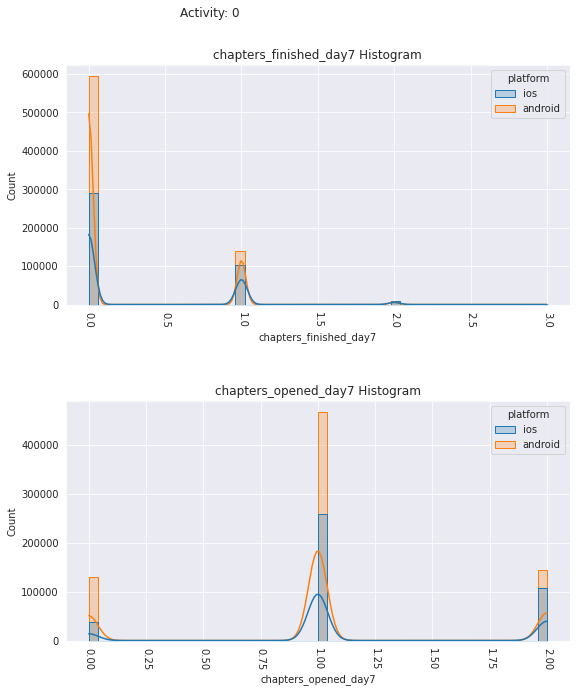

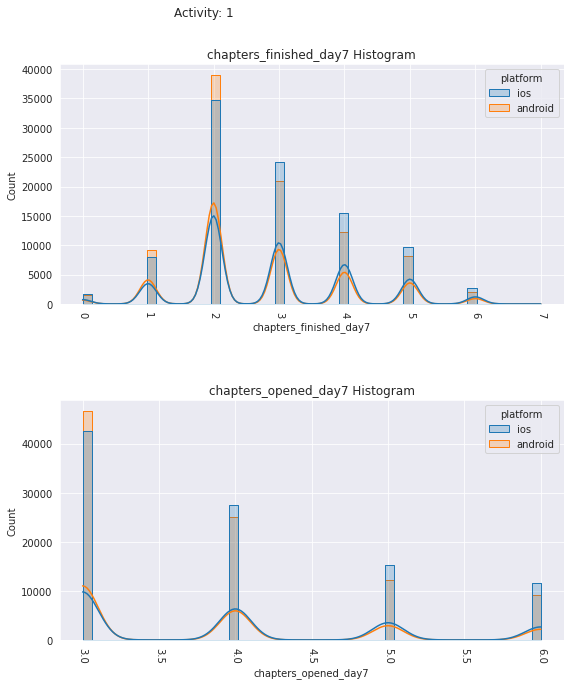

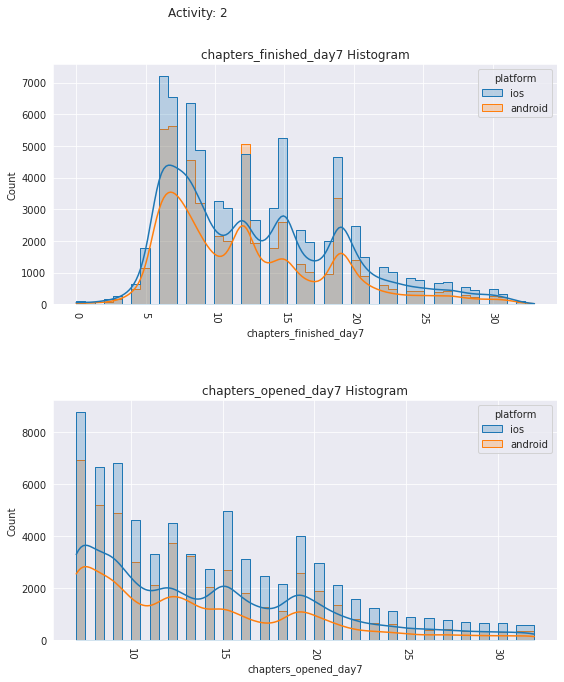

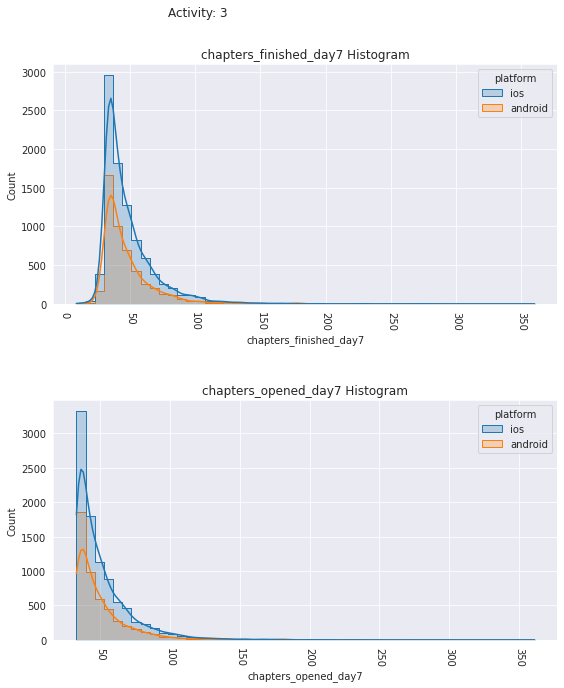

""


In [72]:
act2_df.groupby('activity').apply(lambda x: show_dis_by_group(x, 'platform', num_cols, fig_title=f'Activity: {x.name}'))

Among less active users - more Android, among more active - IOS.  
IOS and Android have different distributions of current feature. This again proves that we need to split all dataset in 2 platforms and build seperate model for each part.

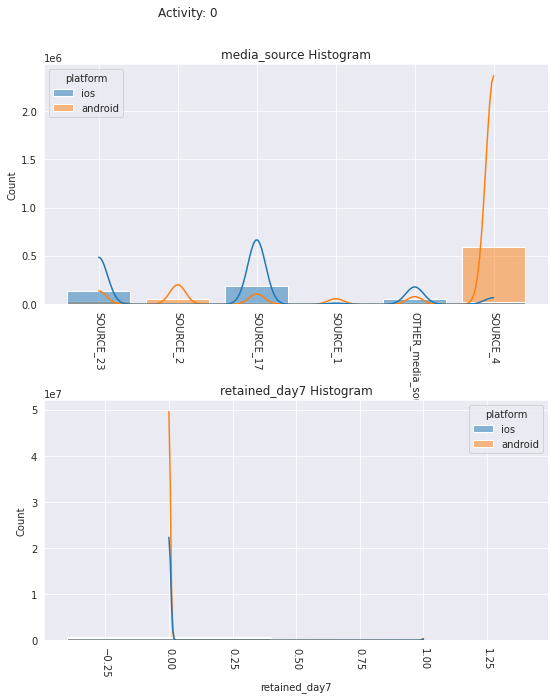

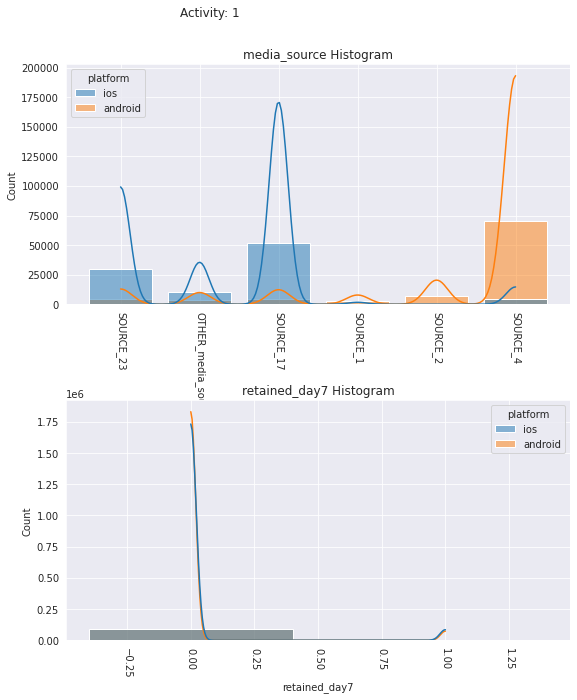

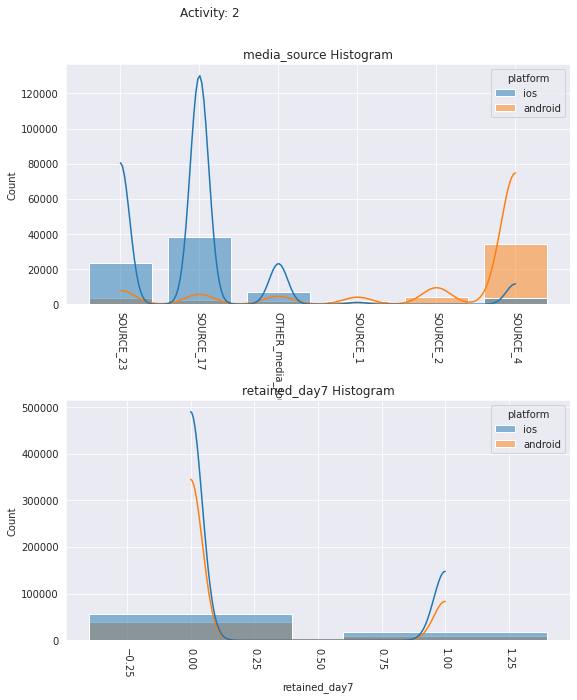

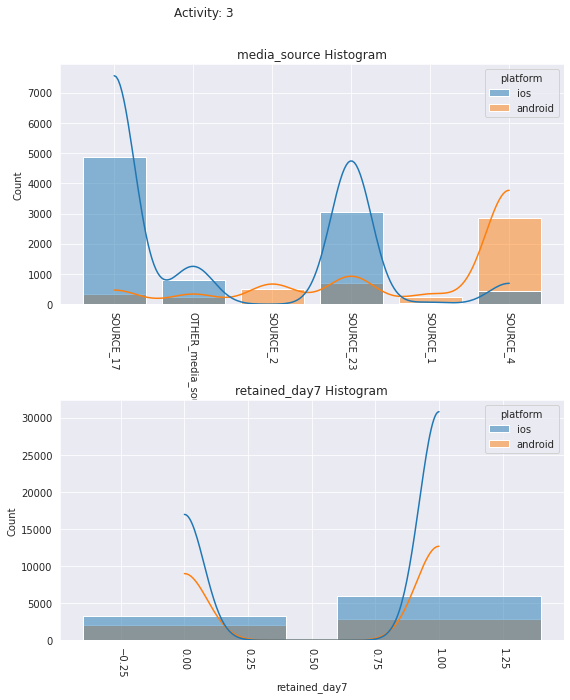

""


In [73]:
act2_df.groupby('activity').apply(lambda x: show_dis_by_group(x, 'platform', [col for col in cat_cols if col not in ['platform', 'country_code']], features_type='cat', fig_title=f'Activity: {x.name}'))

IOS users - sources 17 and 32, Android - 4.

Different distributions of retained users for IOS and Android.

## Summary <a class="anchor" name="summary"></a>

We can observe the difference in payment ability between ios and andriod users, the first one are more able to spend money on game currency (tickets, diamonds). Also features related to diamonds (**diamonds_received_day**, **diamonds_spent_session**, **diamonds_spent_day**) have higher correlation with our target variable (**target_full_ltv_day30**) rather tickets features. So it might be a good idea to include diamond features in the model, because they are more correlated with target and have high variance.

All features have different distributions for platforms. Therefore, build seperate model for each platform.

## Select Top Categories & One-Hot Encoding <a class="anchor" name="select_top_categories_&_one_hot_encoding"></a>

In [74]:
def oh_encode(df, category):
    oh_col = pd.get_dummies(df[category])
    df = df.drop(category, axis=1)
    df = df.join(oh_col)
    df[oh_col.columns] = df[oh_col.columns].astype('int64')

    return df


# Computes top categories for IOS and Android based on target_full_ltv_day30
top_ios_countries = select_top_n(ios, 'country_code', TARGET, 10)
top_ios_sources = select_top_n(ios, 'media_source', TARGET, 5)
top_android_countries = select_top_n(android, 'country_code', TARGET, 10)
top_android_sources = select_top_n(android, 'media_source', TARGET, 5)

top_categories_ios = {'country_code': top_ios_countries,
                      'media_source': top_ios_sources}
top_categories_android = {'country_code': top_android_countries,
                          'media_source': top_android_sources}
top_categories = {'ios': top_categories_ios,
                  'android': top_categories_android}
platform_dfs = {'ios': [ios, denoised_ios_df],
                'android': [android, denoised_android_df]}

# Merges unpopular categories
for platform in ['ios', 'android']:
    for df in platform_dfs[platform]:
        for category in ['country_code', 'media_source']:
            df = merge_unpopular_categories(df, category, top_categories[platform][category])

for category in ['country_code', 'media_source']:
    ios = oh_encode(ios, category)
    denoised_ios_df = oh_encode(denoised_ios_df, category)
    android = oh_encode(android, category)
    denoised_android_df = oh_encode(denoised_android_df, category)

## Converting cumulative values to discrete <a class="anchor" name="converting_cumulative_values_to_discrete"></a>

In [75]:
CUMULATIVE_COLUMNS = [
    'app_sub_ltv_day', 'app_iap_ltv_day', 'ad_ltv_day',
    'chapters_finished_day', 'chapters_opened', 'diamonds_received_day',
    'diamonds_spent_day', 'tickets_spent_day', 'tickets_spent_session',
    'diamonds_spent_session', 'total_sessions_day', 'chapters_finished_session',
    'chapters_opened_session', 'chapters_closed_session'
    ]

ios = transform_all_cumulative(ios, CUMULATIVE_COLUMNS)
denoised_ios_df = transform_all_cumulative(denoised_ios_df, CUMULATIVE_COLUMNS)
android = transform_all_cumulative(android, CUMULATIVE_COLUMNS)
denoised_android_df = transform_all_cumulative(denoised_android_df, CUMULATIVE_COLUMNS)

## Model Building&Interpretation Utils <a class="anchor" name="model_building&_interpretation_utils"></a>

In [76]:
def kft_split(df, target, stratify=None):
    '''
    Return dictionary of form
    {'test': test_idx,
     'sep_0': {'train': train_idx,
                'valid': valid_idx},
     ...,
     'sep_9': ...}
    '''
    if stratify is None:
        stratify = target
    
    split_dict = {}

    X = df.drop(target, axis=1)
    y = df[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=0, stratify=df[stratify])
    
    split_dict['test'] = X_test.index

    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
    
    stratify_train = X_train[stratify]
    i = 0
    for train_idx, valid_idx in skf.split(X_train, stratify_train):
        # fold_X_train, fold_X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        # fold_y_train, fold_y_valid = y[train_idx], y[valid_idx]
        split_dict[f'sep_{i}'] = {'train': train_idx,
                                  'valid': valid_idx}
        i += 1

    return split_dict

def save_obj_pkl(obj, f_name):
    with open(f_name, 'wb') as handle:
        pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [77]:
# android['payable'] = np.where(android[TARGET] > 1, 1, 0)
# kft_dict = kft_split(android, TARGET, 'payable')
# save_obj_pkl(kft_dict, './android_kft.pkl')

In [78]:
def encode_categorical(df):
    """
    Checks for string columns and applies encoder to them
    """
    for feature in df.columns:
        if df[feature].dtype == 'object':
            df[feature] = LabelEncoder().fit_transform(df[feature])

    return df

def split_data(data, denoised_data, insolvent_size, target_name, full=False):
    """
    Splits data on the train and test sets
    """
    data = data[~data.isin(denoised_data)].dropna()
    if not full:
        data = data.sample(insolvent_size)
    data = data[denoised_data.columns]

    X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=[target_name]),
                                                        data[target_name], test_size=0.1)
    
    X_train_denoised, X_test_denoised, y_train_denoised, y_test_denoised = train_test_split(
                                                        denoised_data.drop(columns=[target_name]),
                                                        denoised_data[target_name], test_size=0.1
                                                        )
    
    X_train, y_train = X_train.append(X_train_denoised), y_train.append(y_train_denoised)
    X_test, y_test = X_test.append(X_test_denoised), y_test.append(y_test_denoised)

    return X_train, X_test, y_train, y_test

def save_data(X_train, X_test, y_train, y_test, target, prefix):
    """
    Saves train/test data in corresponding folders
    """
    data_train, data_test = X_train, X_test
    data_train[target], data_test[target] = y_train, y_test

    data_train.to_csv(f'./{prefix}/train.csv', index=False)
    data_test.to_csv(f'./{prefix}/test.csv', index=False)


def model_results(model, X_train, X_test, y_train, y_test):
    """
    Prints model metrics and represents scatterplot of real and predicted values
    """
    # sampled = ios.sample(10000)
    # X_test, y_test = sampled.drop(columns=TO_DROP+[TARGET]), sampled[TARGET]

    y_hat_train = model.predict(X_train)
    y_hat_test = model.predict(X_test)

    print('TRAIN METRICS')
    print('R2:', r2_score(y_train, y_hat_train),
          '\nMAPE:', mean_absolute_percentage_error(y_train, y_hat_train),
          '\nRMSE:', mean_squared_error(y_train, y_hat_train, squared=False),
          '\nMAE:', mean_absolute_error(y_train, y_hat_train),
          '\n')

    print('TEST METRICS')
    print('R2:', r2_score(y_test, y_hat_test),
          '\nMAPE:', mean_absolute_percentage_error(y_test, y_hat_test),
          '\nRMSE:', mean_squared_error(y_test, y_hat_test, squared=False),
          '\nMAE:', mean_absolute_error(y_test, y_hat_test),
          '\nMAX diff:', np.abs(y_test-y_hat_test).max(),
          '\nMIN diff:', np.abs(y_test-y_hat_test).min())

    plt.figure(figsize=(10, 5))
    sns.scatterplot(x=y_hat_test,
                  y=y_test,
                  s=10)
    plt.title('Residuals')
    plt.xlabel('Y Hat')
    plt.ylabel('Y')
    plt.show()


def tune_model(estimator, search_space, X_train, y_train):
    """
    Performs Hyperparameters tunning with Bayesian Optimization
    Need to pass estimator, parameters space and training data
    """
    skf = StratifiedKFold(n_splits=5,
                      shuffle=True, 
                      random_state=42)

    y_stratified = pd.cut(y_train_ios.rank(method='first'), bins=10, labels=False)
    cv = list(skf.split(X_train_ios, y_stratified))
    scoring = make_scorer(partial(mean_squared_error, squared=False), 
                        greater_is_better=False)

    estimator = estimator()

    optimizer = BayesSearchCV(estimator=estimator,                                    
                        search_spaces=search_spaces,                      
                        scoring=scoring,                                  
                        cv=cv,                                           
                        n_iter=12,
                        n_points=1,
                        n_jobs=1,
                        iid=False,
                        return_train_score=False,                         
                        refit=False,                                      
                        optimizer_kwargs={'base_estimator': 'GP'},
                        random_state=0)

    optimizer.fit(X_train, y_train)

    return optimizer

def interpret_model(model):
    """
    Plots features importance
    """
    feature_importance = model.get_booster().get_score(importance_type='weight')
    features = list(feature_importance.keys())
    scores = list(feature_importance.values())

    data = pd.DataFrame(data=scores, index=features, columns=["score"]).sort_values(by="score", ascending=False)
    data.nlargest(40, columns="score").plot(kind='barh', figsize=(20,10), color='darkslateblue')

    plt.title('Feature Importance')
    plt.show()

In [79]:
TO_DROP = ['install_date', 'platform'] + SUBTARGETS

denoised_ios_df_train = denoised_ios_df.drop(columns=TO_DROP)
denoised_android_df_train = denoised_android_df.drop(columns=TO_DROP)

X_train_ios, X_test_ios, y_train_ios, y_test_ios = split_data(ios, denoised_ios_df_train, 100000, TARGET)
X_train_android, X_test_android, y_train_android, y_test_android = split_data(android, denoised_android_df_train, 100000, TARGET)

## Model Training <a class="anchor" name="model_training"></a>

In [80]:
eval_set_ios = [(X_test_ios, y_test_ios)]
eval_set_android = [(X_test_android, y_test_android)]

model_args = {
              'learning_rate': .2,
              'n_estimators': 300,
              'max_depth': 11,
              'gamma': 0.4,
              'random_state': 42,
              'eval_metric': "mae"
              }


xgb_ios = XGBRegressor().fit(X_train_ios, y_train_ios,
                                    early_stopping_rounds=10,
                                    eval_metric="mae",
                                    eval_set=eval_set_ios,
                                    verbose=False)

[18:34:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


TRAIN METRICS
R2: 0.8804389560469705 
MAPE: 139093550099936.39 
RMSE: 1.1691844111684724 
MAE: 0.37455324785105726 

TEST METRICS
R2: 0.8441666366060253 
MAPE: 138541839636398.06 
RMSE: 1.416876437937228 
MAE: 0.3846472515355761 
MAX diff: 79.32374124904857 
MIN diff: 4.9528736048021216e-05


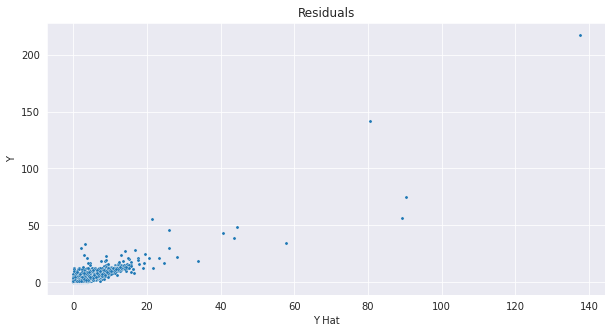

In [81]:
model_results(xgb_ios, X_train_ios, X_test_ios, y_train_ios, y_test_ios)

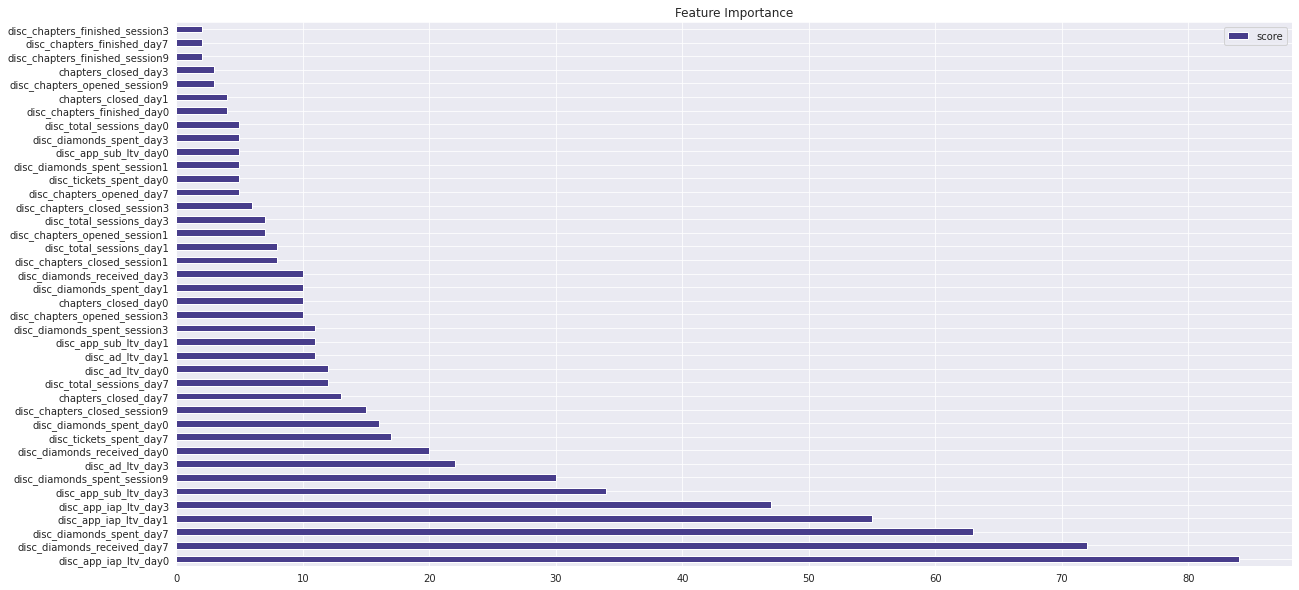

In [82]:
interpret_model(xgb_ios)

In [83]:
xgb_android = XGBRegressor().fit(X_train_android, y_train_android,
                                    early_stopping_rounds=10,
                                    eval_metric="mae",
                                    eval_set=eval_set_android,
                                    verbose=False)

[18:34:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


TRAIN METRICS
R2: 0.9016875521531191 
MAPE: 44729832631463.52 
RMSE: 0.6920337385434151 
MAE: 0.14676616501059045 

TEST METRICS
R2: 0.8379675842962412 
MAPE: 44603082226175.06 
RMSE: 0.7833923971830414 
MAE: 0.15622489638473339 
MAX diff: 40.77428170171777 
MIN diff: 2.3257209401059478e-05


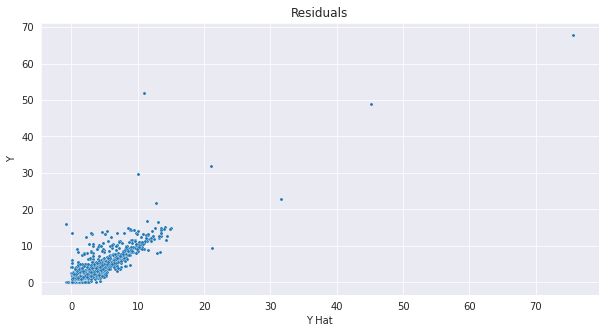

In [84]:
model_results(xgb_android, X_train_android, X_test_android, y_train_android, y_test_android)

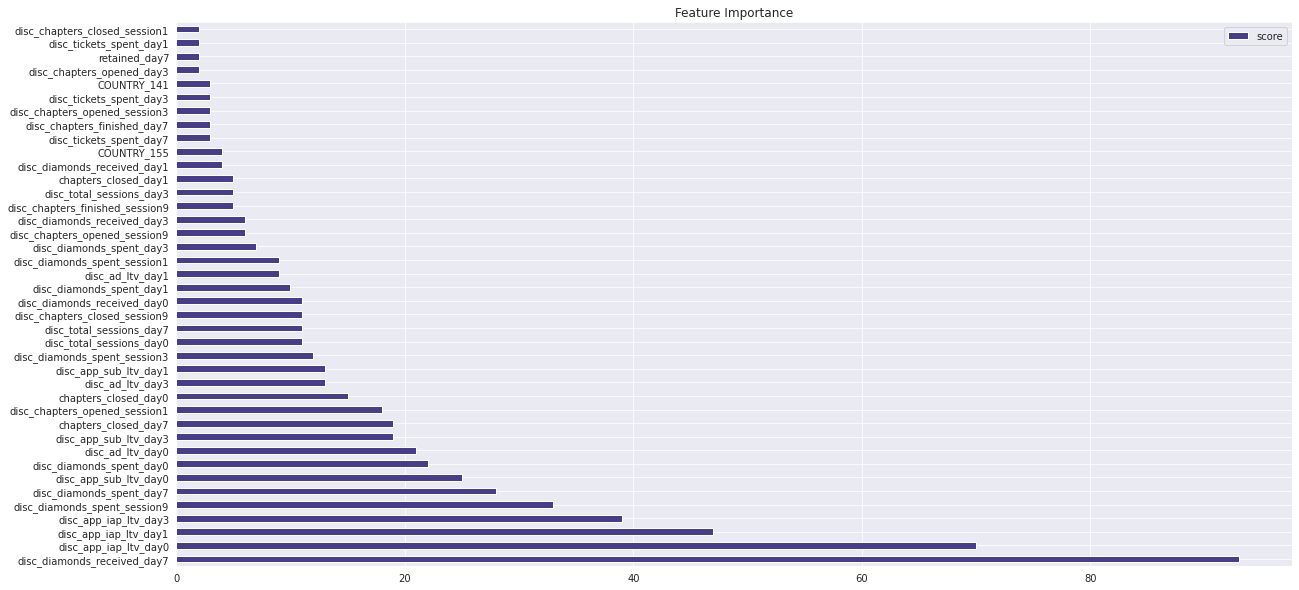

In [85]:
interpret_model(xgb_android)

In [86]:
# search_spaces_xgb = {
#                  'learning_rate': Real(0.2, 0.6, 'uniform'),
#                  'max_depth': Integer(2, 10),
#                  'subsample': Real(0.2, 0.6, 'uniform'),
#                  'colsample_bytree': Real(0.2, 0.6, 'uniform'),
#                  'reg_lambda': Real(0.01, 5, 'uniform'),
#                  'reg_alpha': Real(0.01, 5, 'uniform'),
#                  'n_estimators': Integer(100, 1000)
#    }

# optimizer_ios_xgb = tune_model(XGBRegressor, search_spaces_xgb, X_train_ios, y_train_ios)
# optimizer_ios_xgb.best_params_

In [87]:
# optimizer_android_xgb = tune_model(XGBRegressor, search_spaces_xgb, X_train_android, y_train_android)
# optimizer_android_xgb.best_params_

In [88]:
# search_spaces_rf = {
#         'bootstrap': [True, False],
#         'max_depth': [i for i in range(5, 30, 5)],
#         'max_features': ['auto', 'sqrt'],
#         'min_samples_leaf': [1, 2, 4],
#         'min_samples_split': [2, 5, 10],
#         'n_estimators': [i for i in range(100, 1201, 100)]
# }

# optimizer_ios_rf = tune_model(RandomForestRegressor, search_spaces_rf, X_train_ios, y_train_ios)
# optimizer_ios_rf.best_params_

In [89]:
# optimizer_android_rf = tune_model(RandomForestRegressor, search_spaces_rf, X_train_android, y_train_android)
# optimizer_android_rf.best_params_

In [90]:
# save_data(X_train_ios, X_test_ios, y_train_ios, y_test_ios, TARGET, 'ios')
# save_data(X_train_android, X_test_android, y_train_android, y_test_android, TARGET, 'android')